In [ ]:
import numpy as np
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from Align_time import *
from Norm_TF import *

In [5]:
from Visual_YSC import *
from Sim_YSC import *
from Analysis_YSC import *

In [6]:
data_dir = 'data/Yap_Sox2/'

# Collect and preprocess data

In [7]:
dat = pd.read_csv(data_dir+'all_extracted.csv', index_col = [0,1])

In [8]:
samples = np.array(dat.index.get_level_values(0).unique())

In [9]:
len(samples)

6

In [10]:
# normalize TF
minmax_tf('Sox2', dat); mean_tf('Sox2', dat); zscore_tf('Sox2', dat)
minmax_tf('Total_Sox2', dat); mean_tf('Total_Sox2', dat); zscore_tf('Total_Sox2', dat)
minmax_tf('Yap', dat); mean_tf('Yap', dat); zscore_tf('Yap', dat)

In [11]:
mins_sox2 =  dat.groupby(['stack', 'Time'])['Smooth_Total_Sox2_Minmax'].min()
dat['Smooth_Total_Sox2_Minmax_corr'] =dat['Smooth_Total_Sox2_Minmax']-mins_sox2.loc[dat.reset_index().set_index(['stack', 'Time']).index].values

## Stop at 33 cell stage

In [12]:
dat_full = dat.copy()

In [13]:
thres_times = {}
for st in samples:
    thres_times[st] = dat_full.loc[st].query('Gen == 3').groupby('Branch')['Time'].max().min()
#thres_times
dat = pd.concat([dat_full.loc[st].query('Time <= '+str(thres_times[st]+2)) for st in samples], 
                axis = 0,
               keys = samples).copy()

In [14]:
# normalize time
dat = warp_time(dat)
dat = gen16_time(dat)
dat = gen32_time(dat)

In [15]:
dat['Gen_time'] = 0
dat['Gen_time'][dat['Gen'] == 2]=dat['Gen16_time'][dat['Gen'] == 2]
dat['Gen_time'][dat['Gen'] == 3]=dat['Gen32_time'][dat['Gen'] == 3]

In [16]:
dat.index.names = ['stack', 'ind']

## Stage lengths after subsetting until 33 cell stage

In [17]:
ccl_16_sm = (dat.query('Gen == 2').reset_index()[['stack', 'SmallBranch', 'Time']].drop_duplicates().groupby(['stack', 'SmallBranch', ]).size()/4).reset_index()
ccl_16_sm.columns = ['stack', 'SmallBranch', 'Cell_cycle_length']
ccl_32_sm = (dat.query('Gen == 3').reset_index()[['stack', 'SmallBranch', 'Time']].drop_duplicates().groupby(['stack', 'SmallBranch',]).size()/4).reset_index()
ccl_32_sm.columns = ['stack', 'SmallBranch','Cell_cycle_length']

In [18]:
sns.set(style = 'white', font_scale = 1.5)

Text(0.5, 0.98, 'YAP-SOX2')

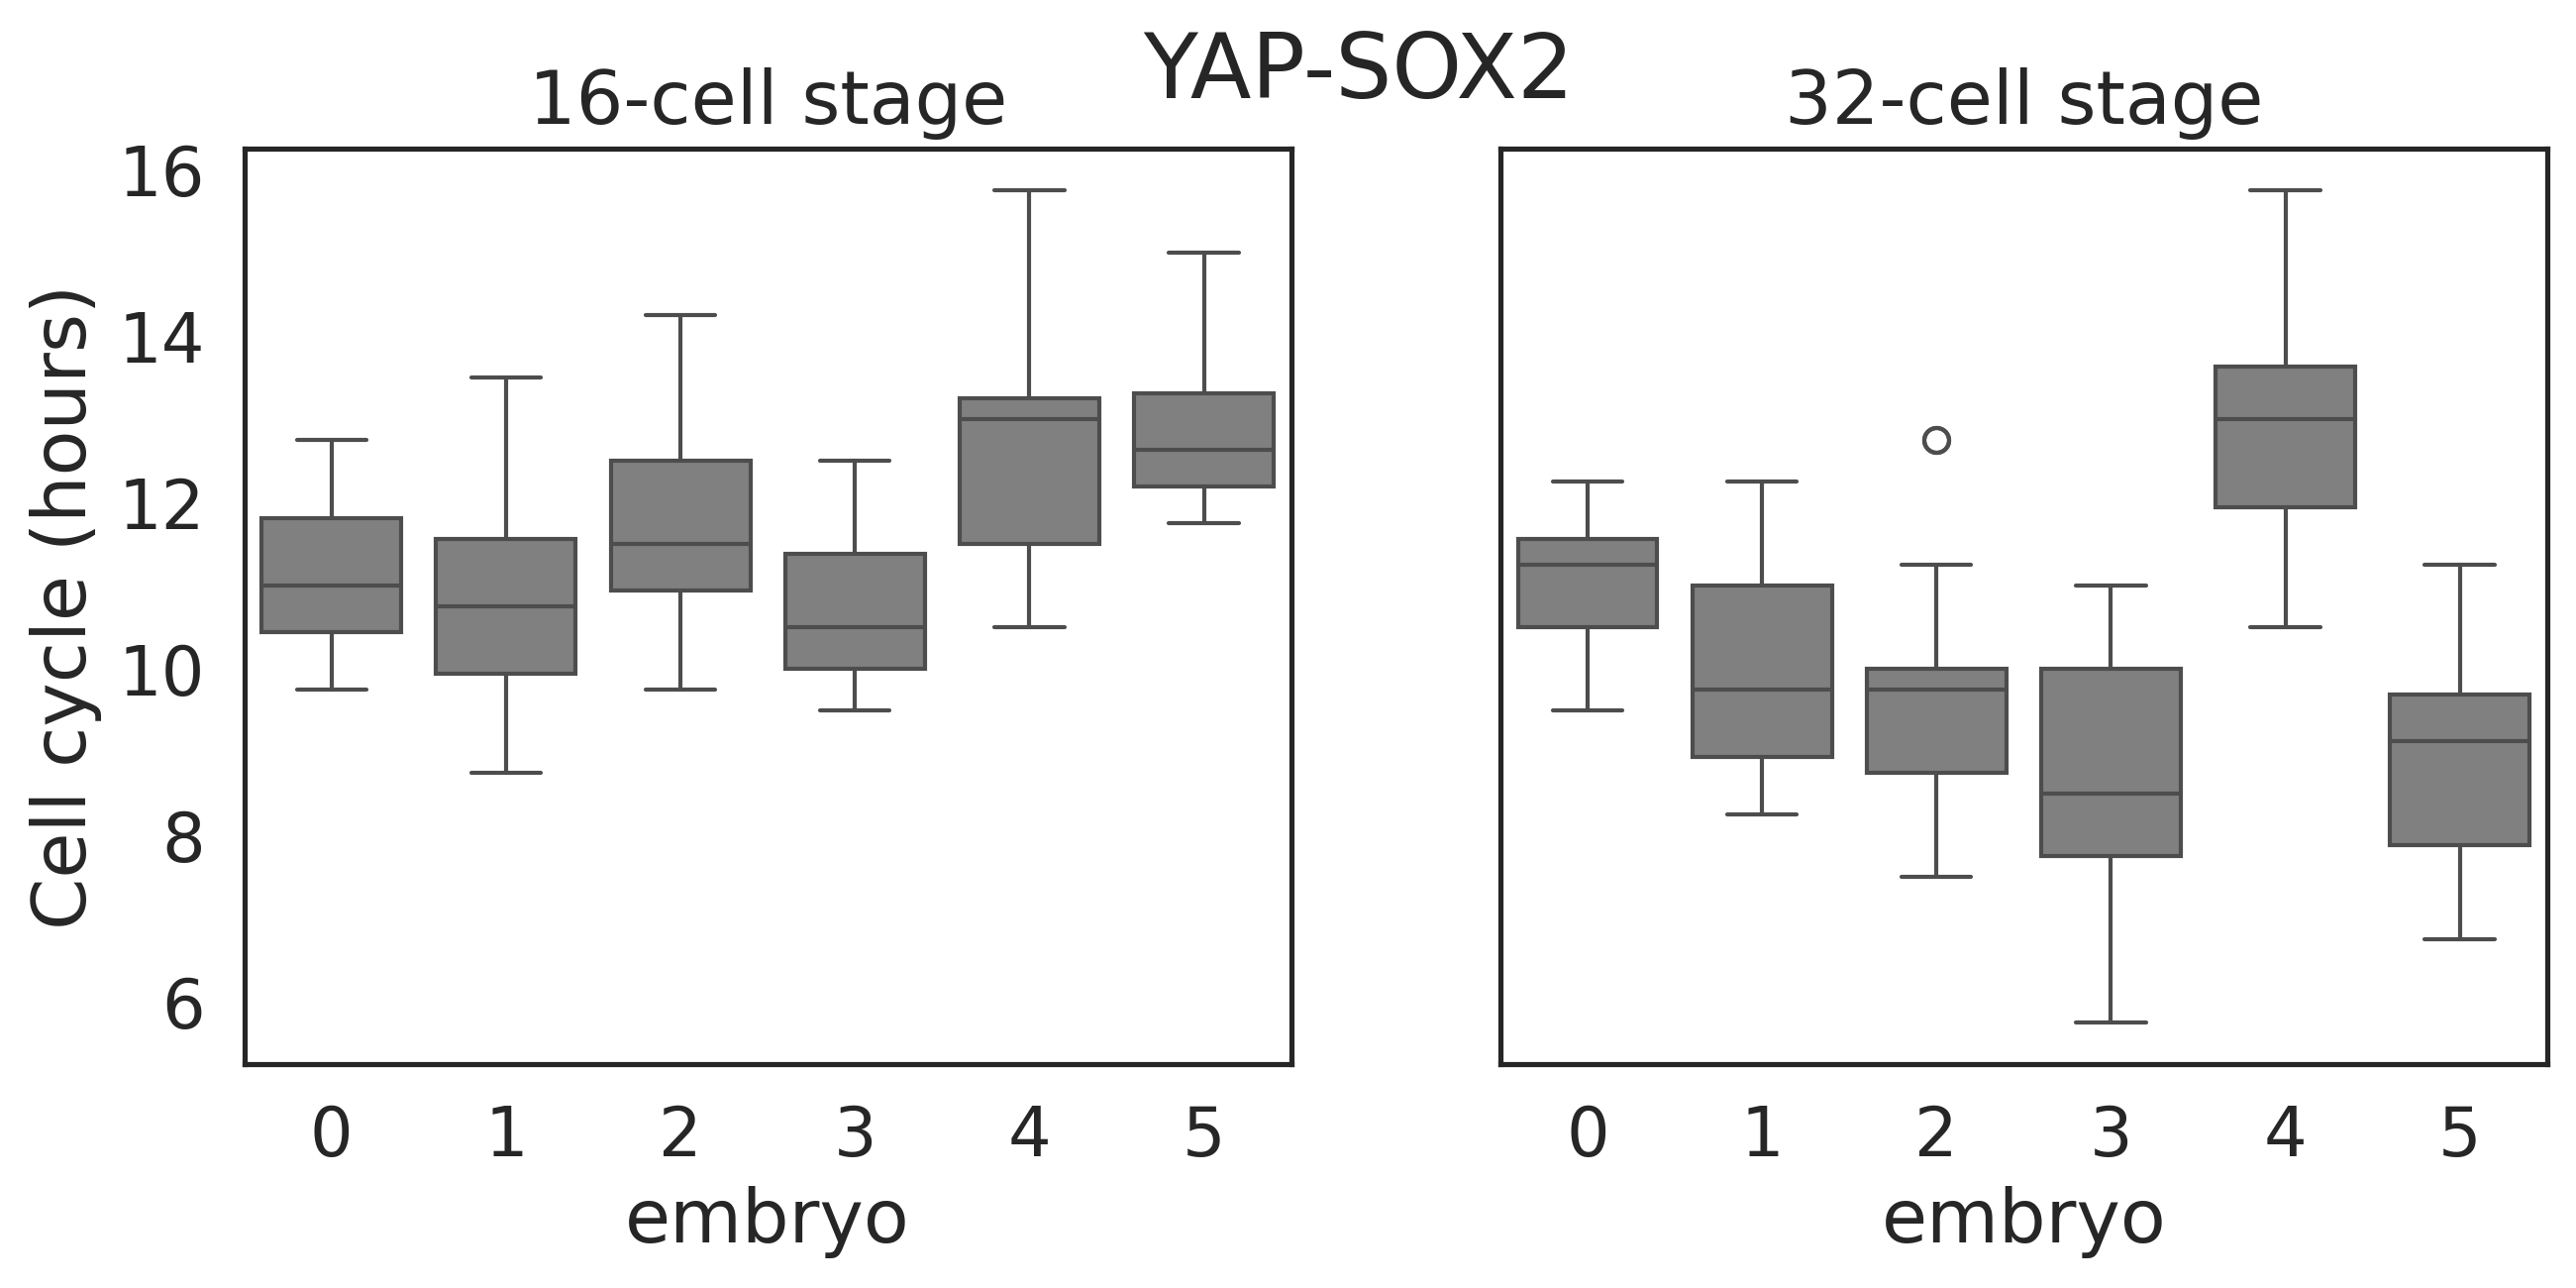

In [19]:
fig, axes = plt.subplots(1,2, dpi = 300, figsize = (10,4), sharey = True)
ax = axes[0]
sns.boxplot(ccl_16_sm, x = 'stack', y = 'Cell_cycle_length', ax = ax, color = 'grey')
ax.set_xticks(rotation = 0, ticks = range(6),
               labels = [str(i) for i in range(6)])
ax.set_xlabel('embryo')
ax.set_ylabel('Cell cycle (hours)')
ax.set_title('16-cell stage')
ax = axes[1]
sns.boxplot(ccl_32_sm, x = 'stack', y = 'Cell_cycle_length', ax = ax, color = 'grey')
ax.set_xticks(rotation = 0, ticks = range(6),
               labels = [str(i) for i in range(6)])
ax.set_xlabel('embryo')
ax.set_title('32-cell stage')
plt.suptitle('YAP-SOX2')
# plt.savefig('figures_for_YSC_Bayesian_paper/S2A_2.png', dpi = 500)
# plt.savefig('figures_for_YSC_Bayesian_paper/S2A_2.svg', dpi = 500)

## Unique branches

In [20]:
dat['Cycle_stage'] = ['Early' if x-int(x)<0.5 else 'Late' for x in dat['Warped_time']]
simp_dat = dat.set_index(['Branch', 'SmallBranch', 'Cycle_stage'], append = True).query('Gen_time>=8')._get_numeric_data().groupby(['stack', 'Gen', 'Cycle_stage', 'Branch']).mean().drop_duplicates()

In [21]:
simp_dat_final = dat.sort_values('Time').set_index(['Gen', 'Branch', 'SmallBranch', 'Cycle_stage'], append = True).query('Gen_time>=8')._get_numeric_data().droplevel(['ind', 'SmallBranch']).groupby(['stack', 'Gen', 'Cycle_stage', 'Branch']).tail(1)#.drop_duplicates()



In [22]:
with_sm = dat.set_index(['Branch', 'SmallBranch'], append = True).query('Gen == 3')._get_numeric_data().groupby(['stack', 'Gen', 'Branch', 'SmallBranch']).mean()
with_sm = with_sm.reset_index('Branch')
with_sm = with_sm[~with_sm.index.duplicated(keep='first')]
with_sm = with_sm.reset_index('stack')
branches_to_keep = list(zip(with_sm['stack'], with_sm['Branch']))
simp_dat_short = simp_dat.loc[[x in branches_to_keep for x in list(zip(simp_dat.reset_index()['stack'], simp_dat.reset_index()['Branch']))],:]

In [23]:
simp_dat_final_short = simp_dat_final.loc[[x in branches_to_keep for x in list(zip(simp_dat_final.reset_index()['stack'], simp_dat_final.reset_index()['Branch']))],:]

In [24]:
dat_copy = dat.copy()
dat_copy = dat_copy.reset_index().set_index(['stack', 'Branch'])
dat_short = dat_copy.loc[dat_copy.index.isin(branches_to_keep),:]

In [25]:
wp_dat_short = dat_short._get_numeric_data().groupby(['stack', 'Branch', 'Warped_time']).mean().reset_index('Warped_time')

In [26]:
beg_16 = wp_dat_short.query('Warped_time > 1.01 and Warped_time <1.09')
mid_16 = wp_dat_short.query('Warped_time > 1.46 and Warped_time <1.54')
end_16 = wp_dat_short.query('Warped_time > 1.91 and Warped_time <1.99')
mid_32 = wp_dat_short.query('Warped_time > 2.46 and Warped_time <2.54')
end_32 = wp_dat_short.query('Warped_time > 2.91 and Warped_time <2.99')

In [27]:
thres_sox2 = 0.08
tv_16 = (end_16-beg_16)['Smooth_Total_Sox2_Minmax_corr']
tv_32_early = (mid_32-beg_16)['Smooth_Total_Sox2_Minmax_corr']
tv_32_late = (end_32-beg_16)['Smooth_Total_Sox2_Minmax_corr']
np.sum(tv_16>thres_sox2), np.sum(tv_32_early>thres_sox2), np.sum(tv_32_late>thres_sox2), 

(42, 39, 59)

In [28]:
early_sox2 = tv_16.loc[tv_16>thres_sox2].index
early_32_sox2 = tv_32_early.loc[tv_32_early>thres_sox2].index
late_sox2 = tv_32_late.loc[tv_32_late>thres_sox2].index

In [29]:
dat_copy = dat.copy()
dat_copy = dat_copy.reset_index().set_index(['stack', 'Branch'])
dat_short = dat_copy.loc[dat_copy.index.isin(branches_to_keep),:]

# Classification

## Sox2

In [30]:
np.random.seed(0)

In [31]:
Sox2_16_late = tv_16#simp_dat_final_short.query('Gen == 2').query('Cycle_stage == "Late"')['Smooth_Total_Sox2_Minmax_corr']
vls = tv_16.values.reshape(-1,1)#Sox2_16_late.values.reshape(-1,1)
lbs = np.ravel((vls>thres_sox2).astype(int))
lbs = pd.Series(lbs,#[args[lb] for lb in lbs],
                index = Sox2_16_late.index).astype(str)
dat_short['16cs_SOX2_late_status'] = lbs.loc[dat_short.reset_index().set_index(['stack', 'Branch']).index]

In [32]:
Sox2_32_early = tv_32_early#simp_dat_final_short.query('Gen == 2').query('Cycle_stage == "Late"')['Smooth_Total_Sox2_Minmax_corr']
vls = tv_32_early.values.reshape(-1,1)#Sox2_16_late.values.reshape(-1,1)
lbs = np.ravel((vls>thres_sox2).astype(int))
lbs = pd.Series(lbs,#[args[lb] for lb in lbs],
                index = Sox2_16_late.index).astype(str)
dat_short['32cs_SOX2_early_status'] = lbs.loc[dat_short.reset_index().set_index(['stack', 'Branch']).index]

In [33]:
Sox2_32_late = tv_32_late#simp_dat_final_short.query('Gen == 2').query('Cycle_stage == "Late"')['Smooth_Total_Sox2_Minmax_corr']
vls = tv_32_late#Sox2_16_late.values.reshape(-1,1)
lbs = np.ravel((vls>thres_sox2).astype(int))
lbs = pd.Series(lbs,#[args[lb] for lb in lbs],
                index = Sox2_16_late.index).astype(str)
dat_short['32cs_SOX2_late_status'] = lbs.loc[dat_short.reset_index().set_index(['stack', 'Branch']).index]

In [34]:
dat_short['8cs_SOX2_status'] = '0'
dat_short['16cs_SOX2_early_status'] = '0'

## YAP

In [35]:
thres_yap_early = -0.586417661470855
thres_yap = -0.8169255065580239
thres_yap_32_early = -0.6071130370039592
thres_yap_32_late = -0.5796090356007886

In [36]:
yap_16_early = simp_dat_short.query('Gen == 2').query('Cycle_stage == "Early"')['Smooth_Yap_zscore']

In [37]:
yap_16_late = simp_dat_short.query('Gen == 2').query('Cycle_stage == "Late"')['Smooth_Yap_zscore']

In [38]:
yap_32_early = simp_dat_short.query('Gen == 3').query('Cycle_stage == "Early"')['Smooth_Yap_zscore']

In [39]:
yap_32_late = simp_dat_short.query('Gen == 3').query('Cycle_stage == "Late"')['Smooth_Yap_zscore']

In [40]:
high_16cs_yap = yap_16_early.loc[yap_16_early>thres_yap_early,:].index.droplevel(['Gen', 'Cycle_stage'])
low_16cs_yap = yap_16_early.loc[yap_16_early<=thres_yap_early,:].index.droplevel(['Gen', 'Cycle_stage'])
allbr = dat_short.reset_index().set_index(['stack', 'Branch']).index
sts = []
for x in allbr:
    if x in high_16cs_yap:
        sts.append('High')
    elif x in low_16cs_yap:
        sts.append('Low')
    else:
        sts.append(np.nan)
dat_short['16cs_Yap_early_status'] = sts

In [41]:
high_16cs_yap = yap_16_late.loc[yap_16_late>thres_yap,:].index.droplevel(['Gen', 'Cycle_stage'])
low_16cs_yap = yap_16_late.loc[yap_16_late<=thres_yap,:].index.droplevel(['Gen', 'Cycle_stage'])
allbr = dat_short.reset_index().set_index(['stack', 'Branch']).index
sts = []
for x in allbr:
    if x in high_16cs_yap:
        sts.append('High')
    elif x in low_16cs_yap:
        sts.append('Low')
    else:
        sts.append(np.nan)
dat_short['16cs_Yap_status'] = sts

In [42]:
high_32cs_yap = yap_32_early.loc[yap_32_early>thres_yap_32_early,:].index.droplevel(['Gen', 'Cycle_stage'])
low_32cs_yap = yap_32_early.loc[yap_32_early<=thres_yap_32_early,:].index.droplevel(['Gen', 'Cycle_stage'])
allbr = dat_short.reset_index().set_index(['stack', 'Branch']).index
sts = []
for x in allbr:
    if x in high_32cs_yap:
        sts.append('High')
    elif x in low_32cs_yap:
        sts.append('Low')
    else:
        sts.append(np.nan)
dat_short['32cs_Yap_early_status'] = sts

In [43]:
high_32cs_yap = yap_32_late.loc[yap_32_late>thres_yap_32_late,:].index.droplevel(['Gen', 'Cycle_stage'])
low_32cs_yap = yap_32_late.loc[yap_32_late<=thres_yap_32_late,:].index.droplevel(['Gen', 'Cycle_stage'])
allbr = dat_short.reset_index().set_index(['stack', 'Branch']).index
sts = []
for x in allbr:
    if x in high_32cs_yap:
        sts.append('High')
    elif x in low_32cs_yap:
        sts.append('Low')
    else:
        sts.append(np.nan)
dat_short['32cs_Yap_late_status'] = sts

In [44]:
dat_short['8cs_Yap_status'] = 'High'


In [45]:
simp_dat_info = dat_short.reset_index().set_index(['stack', 'Gen', 'Cycle_stage', 'Branch']).query('Gen_time>=8').select_dtypes(exclude='number').iloc[:, 1:].reset_index().drop_duplicates().set_index(['stack', 'Gen', 'Cycle_stage', 'Branch'])




simp_dat_info_short = simp_dat_info.query('Gen == 2').query('Cycle_stage == "Late"')
simp_dat_info_short = simp_dat_info_short.loc[[x in branches_to_keep for x in list(zip(simp_dat_info_short.reset_index()['stack'], simp_dat_info_short.reset_index()['Branch']))],:]



## Example

In [46]:
yap_stats = simp_dat_info_short[['8cs_Yap_status','16cs_Yap_early_status','16cs_Yap_status', '32cs_Yap_early_status', '32cs_Yap_late_status']]
def map_high_low(x):
    if x == 'High':
        return 1
    else:
        return 0
yap_stats = yap_stats.applymap(map_high_low)
Sox2_stats = simp_dat_info_short[['8cs_SOX2_status', '16cs_SOX2_early_status','16cs_SOX2_late_status', '32cs_SOX2_early_status', '32cs_SOX2_late_status']]
#rea_stats = rea_stats.applymap(map_high_low)

In [47]:
def map_to_fs(s_expr):
    if s_expr == (0,0,0,0,0):
        return '$S^-$'
    elif s_expr[2] == 1:
        return '$S^+_{16L}$'
    elif s_expr[3] == 1:
        return '$S^+_{32E}$'
    elif s_expr[4] == 1:
        return '$S^+_{32L}$'
fs = pd.Series([tuple(x) for x in Sox2_stats.values.astype(int)]).map(map_to_fs)
fs = pd.Series(fs.values, index = Sox2_stats.index).droplevel([1,2])
dat_short['Fate_stage'] = fs.loc[dat_short.index]

In [48]:
wp_dat_short = dat_short.set_index(['Fate_stage'], append = True)._get_numeric_data().groupby(['stack', 'Branch', 'Fate_stage',  'Warped_time']).mean().reset_index('Warped_time')

In [49]:
samples = np.unique(dat.index.get_level_values('stack'))

In [50]:
st = samples[0]

In [51]:
#ind_palette = ['dodgerblue', 'magenta','red', 'darkgray']

ind_palette = sns.color_palette('magma', 4)
#cols = ['#1E90FF', '#FF00FF','#FF0000', 'darkgray']
cols = ['dodgerblue', 'magenta', 'red', 'darkgray']
ind_palette = dict(zip([ '$S^+_{16L}$','$S^+_{32E}$','$S^+_{32L}$', '$S^-$'],cols))


Text(0.5, 0, 'Cell stage')

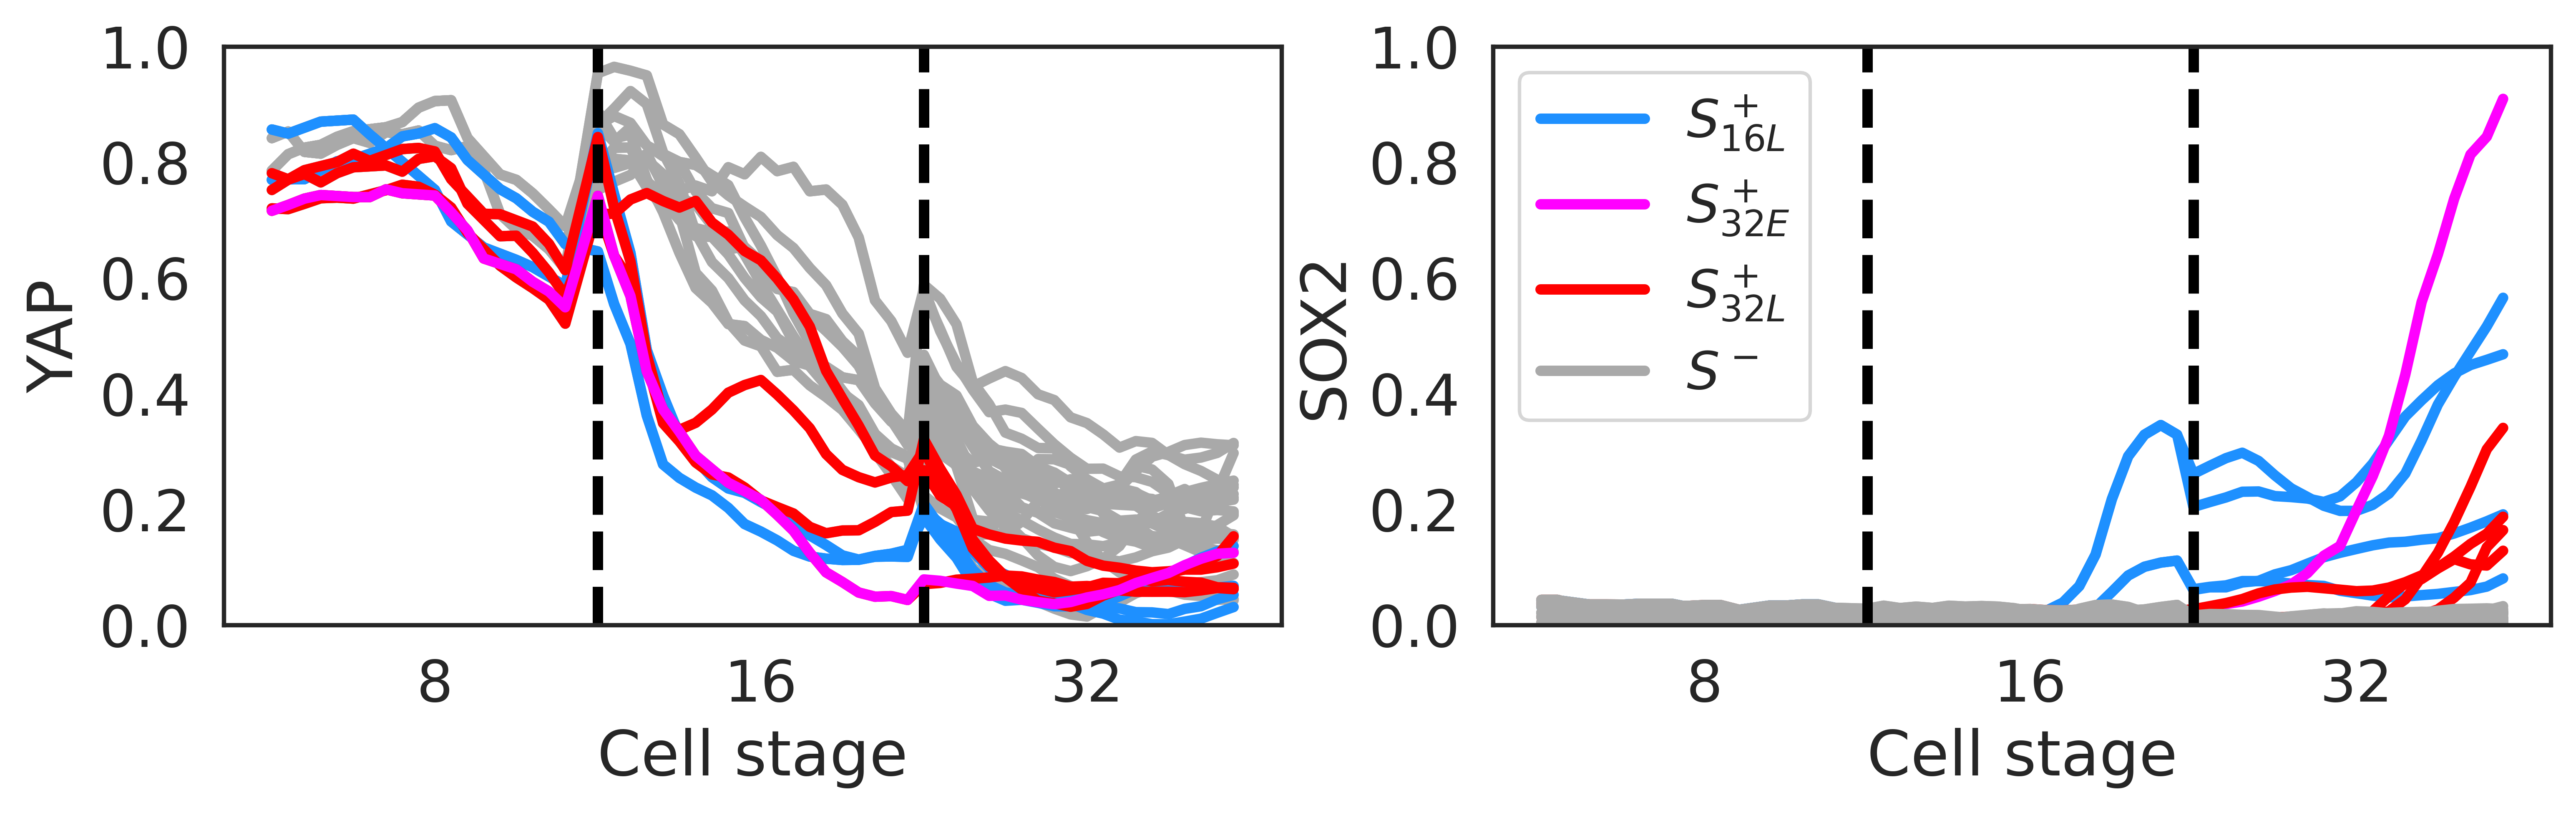

In [52]:
fig, axes = plt.subplots(1,2,dpi = 600, figsize = (12,3), sharey = False)
ax = axes[0]
sns.set(palette = 'nipy_spectral', style = 'white', font_scale = 1.5)
sns.lineplot(wp_dat_short.query('Gen<=3').loc[st], ax = ax,
             estimator = None, lw = 3,
             units = 'Branch', 
             y = 'Smooth_Yap_Minmax',
             x = 'Warped_time', hue= 'Fate_stage', legend = False,
             hue_order = ['$S^-$', '$S^+_{16L}$','$S^+_{32L}$', '$S^+_{32E}$', ],
                                palette = ind_palette)#[ 'darkgray', 'dodgerblue','red', 'magenta', ],)
ax.axvline(1, linestyle = '--', c = 'black', lw = 3)
ax.axvline(2, linestyle = '--', c = 'black', lw = 3)
ax.set_ylabel('YAP')
ax.set_xlabel('')
#ax.legend(title = '', fontsize = 15)
ax.legend = []
ax.set_xticks([0.5, 1.5, 2.5], ['8', '16', '32'])
ax.set_xlabel('Cell stage')
ax.set_ylim(0,1)
ax = axes[1]
sns.set(palette = 'nipy_spectral', style = 'white', font_scale = 1.5)
sns.lineplot(wp_dat_short.query('Gen<=3').loc[st], ax = ax,
             estimator = None, lw = 3,
             units = 'Branch', 
             y = 'Smooth_Total_Sox2_Minmax_corr',
             x = 'Warped_time', hue= 'Fate_stage', 
             legend = True, hue_order = [ '$S^+_{16L}$','$S^+_{32E}$','$S^+_{32L}$', '$S^-$'],
                                palette = ind_palette)#['dodgerblue', 'magenta','red', 'darkgray'],)
ax.axvline(1, linestyle = '--', c = 'black', lw = 3)
ax.axvline(2, linestyle = '--', c = 'black', lw = 3)
ax.set_ylabel('SOX2')
ax.set_xlabel('')
ax.legend(title = '', fontsize = 15)
ax.set_xticks([0.5, 1.5, 2.5], ['8', '16', '32'])
ax.set_ylim(0,1)
ax.set_xlabel('Cell stage')
# plt.savefig('figures_for_YSC_Bayesian_paper/2A.svg')
# plt.savefig('figures_for_YSC_Bayesian_paper/2A.png')

### specific examples

In [53]:
yap_16 = [np.sum(x != [1,0,0,0,0])==0 for x in yap_stats.values]
s16 = [np.sum(x != [0,0,1,1,1])==0 for x in Sox2_stats.astype(int).values]
yap_32l = [np.sum(x != [1,1,1,0,0])==0 for x in yap_stats.values]
s32l = [np.sum(x != [0,0,0,0,1])==0 for x in Sox2_stats.astype(int).values]
bth_s16 = np.array(yap_16)*np.array(s16)
bth_s32l = np.array(yap_32l)*np.array(s32l)
y16_s32 = np.array(yap_16)*np.array(s32l)

In [54]:
yap_trans = [yap_stats.loc[bth_s16,:].droplevel(['Gen', 'Cycle_stage']).index[1]]
yap_trans+= [yap_stats.loc[bth_s32l,:].droplevel(['Gen', 'Cycle_stage']).index[2]]
yap_trans+= [yap_stats.loc[y16_s32,:].droplevel(['Gen', 'Cycle_stage']).index[3]]



In [55]:
to_cons = pd.concat([wp_dat_short.loc[x] for x in yap_trans],
         keys = yap_trans)
to_cons.index.names = ['stack', 'Branch', 'Fate_stage']

In [56]:
sns.set(palette = 'nipy_spectral', style = 'white', font_scale = 1.5)

Text(0.5, 0, 'Cell stage')

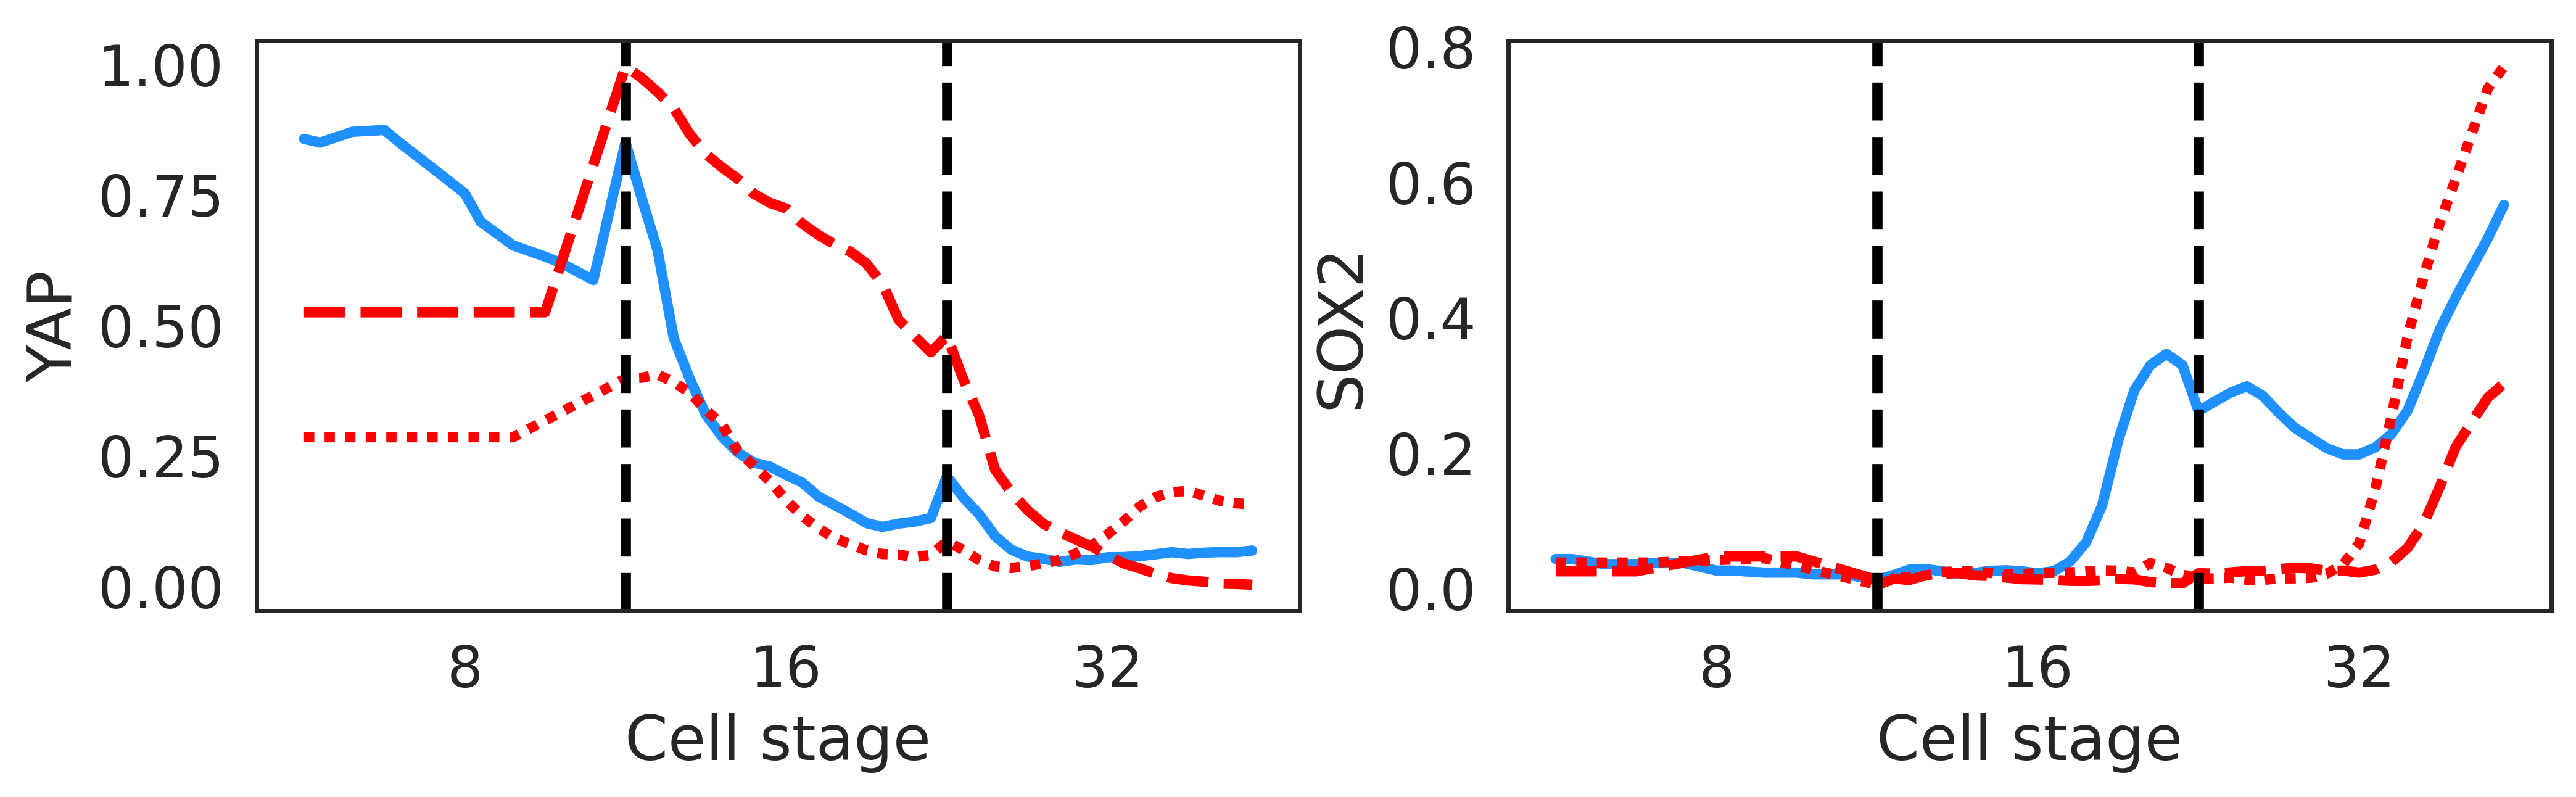

In [57]:
fig, axes = plt.subplots(1,2, dpi = 400, figsize = (12,3))
ax = axes[0]

sns.lineplot(to_cons.query('Gen<=3').reset_index(), estimator = None, lw = 3,
             units = 'Branch', y = 'Smooth_Yap_Minmax', 
             style = 'Branch',
             x = 'Warped_time', hue= 'Fate_stage', legend = False,
             hue_order = [ '$S^+_{16L}$','$S^+_{32E}$', '$S^-$','$S^+_{32L}$'],
                                palette = ['dodgerblue', 'magenta',  'darkgray', 'red',],
            ax = ax)
ax.axvline(1, linestyle = '--', c = 'black', lw = 3)
ax.axvline(2, linestyle = '--', c = 'black', lw = 3)
ax.set_ylabel('YAP')
ax.set_xlabel('')
#plt.legend(title = '', fontsize = 15)
ax.set_xticks([0.5, 1.5, 2.5], ['8', '16', '32'])
ax.set_xlabel('Cell stage')

ax = axes[1]

sns.lineplot(to_cons.query('Gen<=3').reset_index(), estimator = None, lw = 3,
             units = 'Branch', y = 'Smooth_Total_Sox2_Minmax_corr',
             style = 'Branch',
             x = 'Warped_time', hue= 'Fate_stage', legend = False,
             hue_order = [ '$S^+_{16L}$','$S^+_{32E}$', '$S^-$','$S^+_{32L}$'],
                                palette = ['dodgerblue', 'magenta',  'darkgray', 'red',],)
ax.axvline(1, linestyle = '--', c = 'black', lw = 3)
ax.axvline(2, linestyle = '--', c = 'black', lw = 3)
ax.set_ylabel('SOX2')
ax.set_xlabel('')
#plt.legend(title = '', fontsize = 15)
ax.set_xticks([0.5, 1.5, 2.5], ['8', '16', '32'])
ax.set_xlabel('Cell stage')

#plt.tight_layout()
# plt.savefig('figures_for_YSC_Bayesian_paper/S3E.png')
# plt.savefig('figures_for_YSC_Bayesian_paper/S3E.svg')

# Binarized pairwise data

In [58]:
d0 = dat_short.query('Gen == 1').groupby(['stack', 'Branch'])['Smooth_Total_Sox2_Minmax_corr'].mean()
d1 = simp_dat_final_short.query('Gen == 2').query('Cycle_stage == "Early"').groupby(['stack', 'Branch'])['Smooth_Total_Sox2_Minmax_corr'].mean()
d2 = simp_dat_final_short.query('Gen == 2').query('Cycle_stage == "Late"').groupby(['stack', 'Branch'])['Smooth_Total_Sox2_Minmax_corr'].mean()
d3 = simp_dat_final_short.query('Gen == 3').query('Cycle_stage == "Early"').groupby(['stack', 'Branch'])['Smooth_Total_Sox2_Minmax_corr'].mean()
d4 = simp_dat_final_short.query('Gen == 3').query('Cycle_stage == "Late"').groupby(['stack', 'Branch'])['Smooth_Total_Sox2_Minmax_corr'].mean()

In [59]:
rs2 = pd.concat([d0,d1, d2, d3, d4], axis= 1)
rs2.columns = ['0=8','1=16E', '2=16L', '3=32E', '4=32L']
rs = Sox2_stats.droplevel([1,2]).copy()
rs.columns = rs2.columns
inter = rs2.stack().index.intersection(rs.stack().index)
all_rs = rs.stack().loc[inter].reset_index()
all_rs.columns = ['stack', 'Branch', 'Stage', 'Value']
all_rs['SOX2'] = rs2.stack().loc[inter].values
#all_rs['Pos'] = ['Outer' if x else 'Inner' for x in all_rs['Pos']]

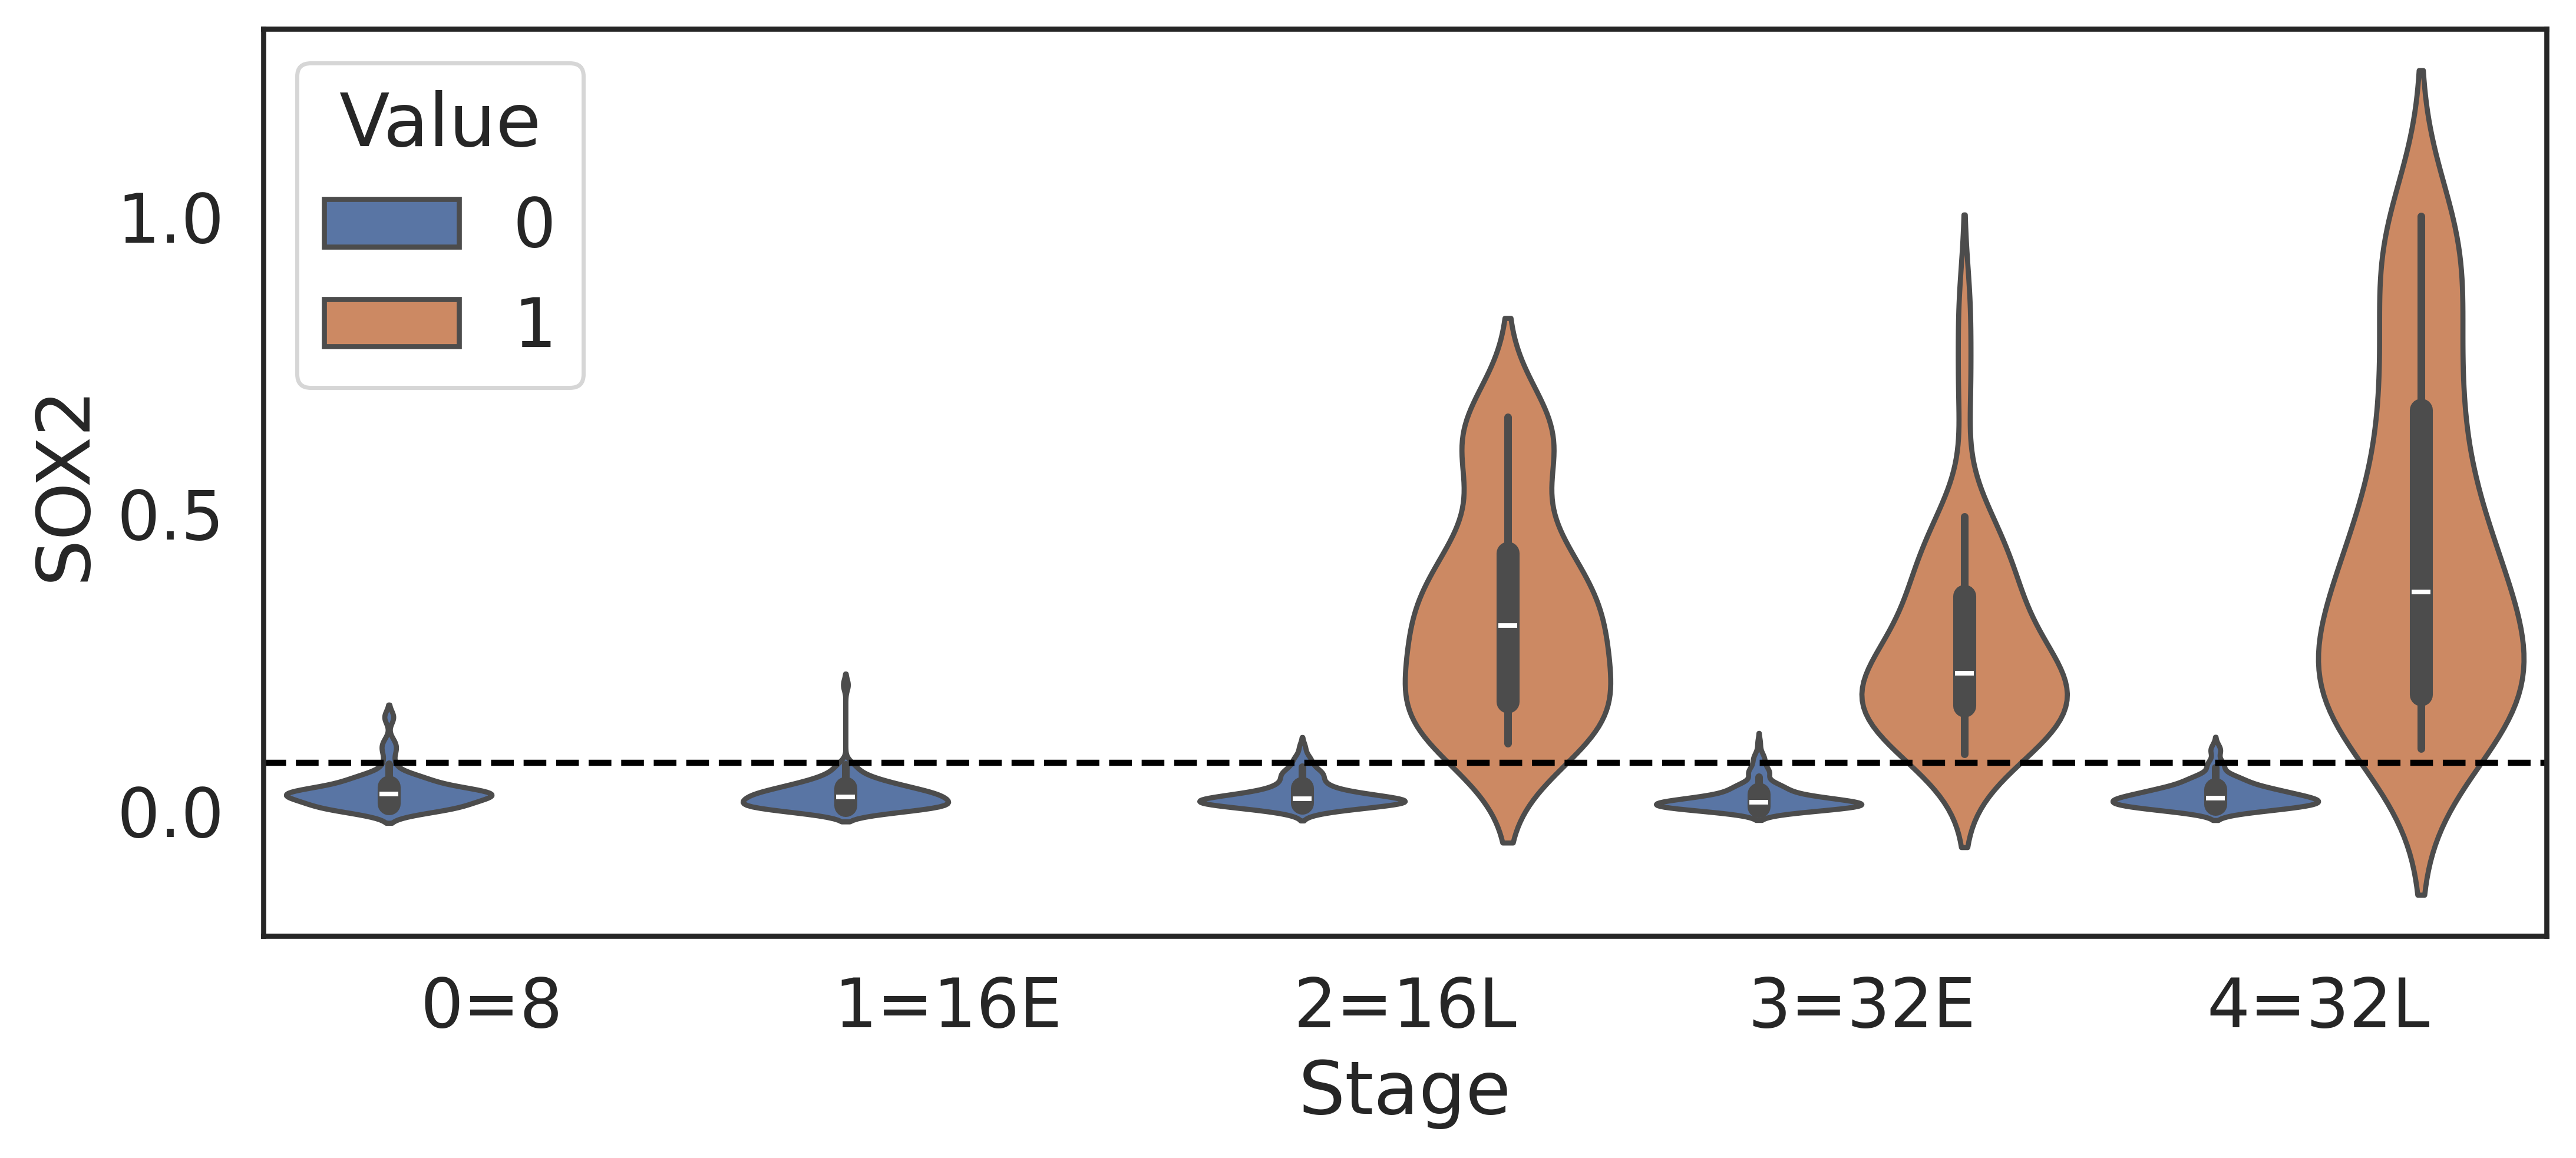

In [60]:
sns.set(style = 'white', font_scale = 1.5)
plt.figure(dpi = 500, figsize = (10,4))
sns.violinplot(data = all_rs, x = 'Stage', y = 'SOX2', 
               hue = 'Value', hue_order = ['0', '1'], 
              #palette = ['limegreen', 'darkmagenta'], 
               density_norm = 'width',
               width = 0.9)
ax = plt.gca()
ax.axhline(thres_sox2, c = 'black', linestyle = '--')
handles, previous_labels = ax.get_legend_handles_labels()

## Example

In [61]:
st = samples[0]

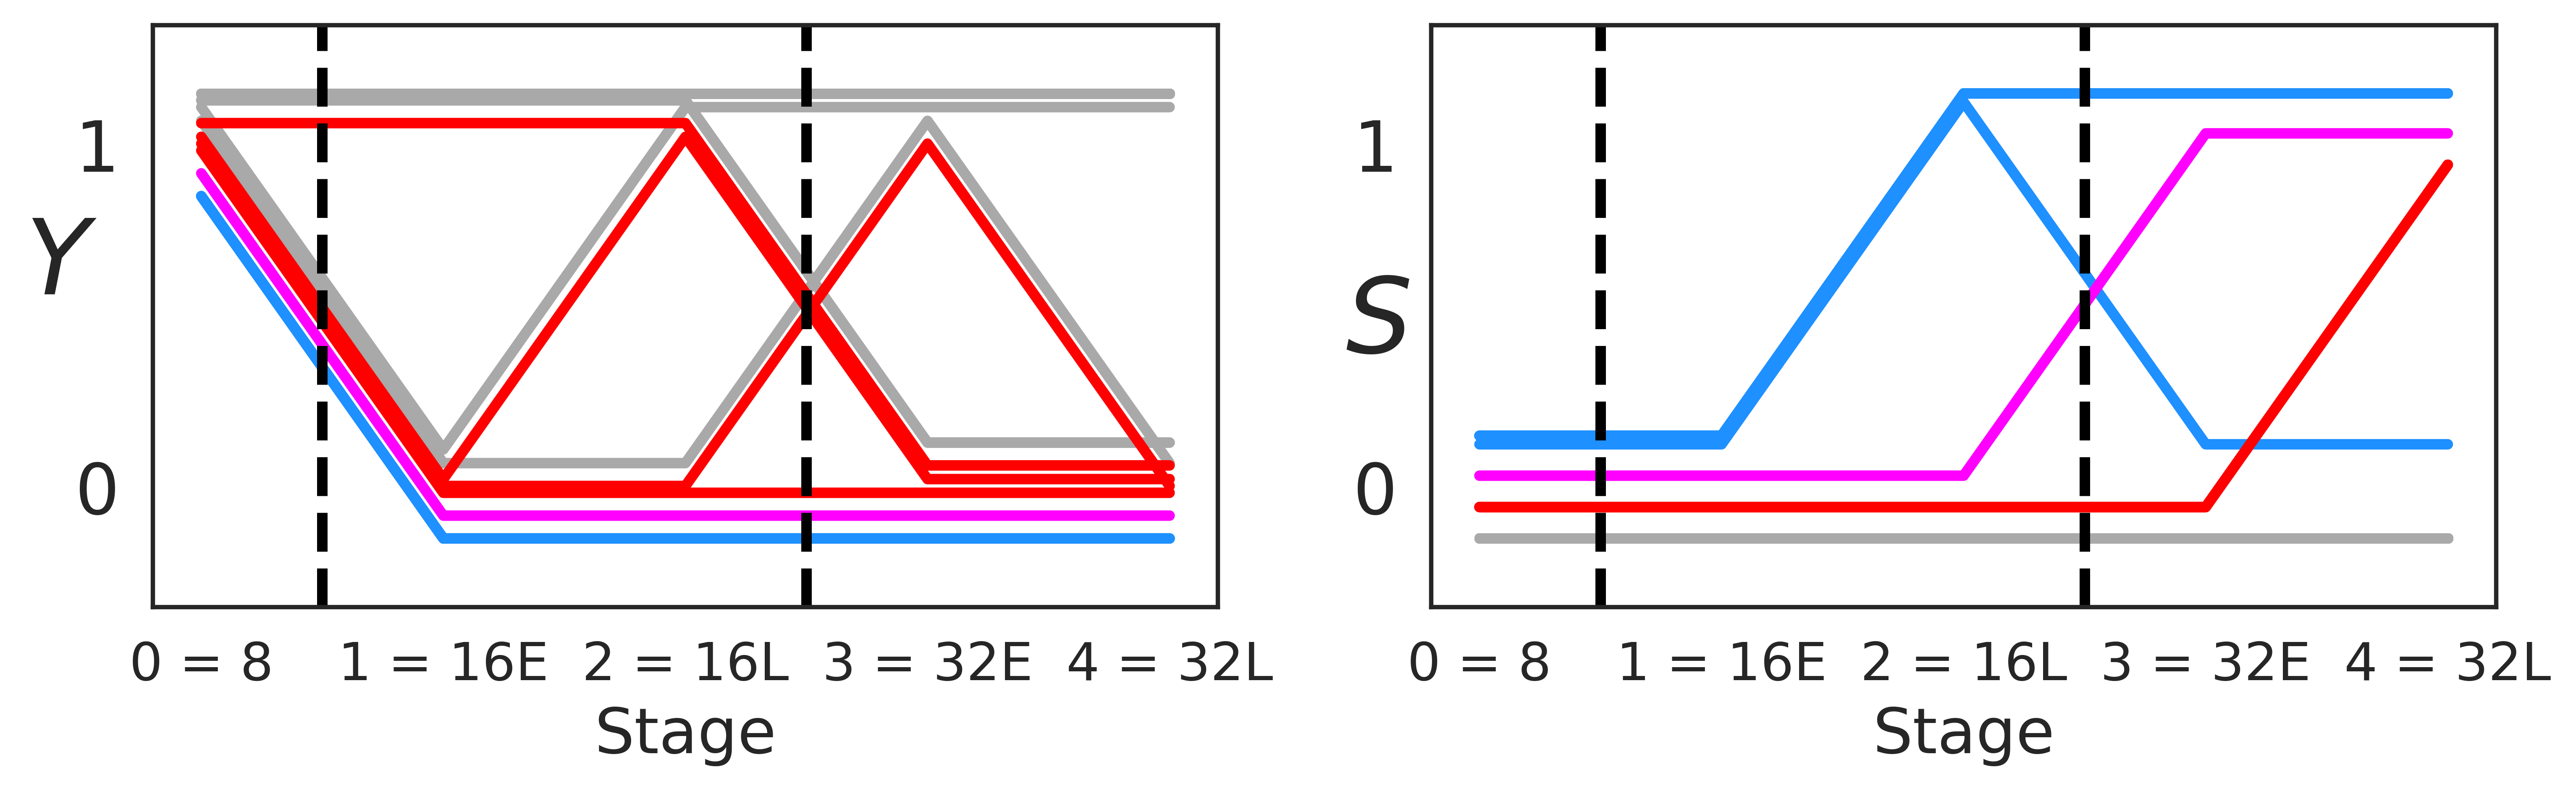

In [62]:
fig, axes = plt.subplots(1,2,dpi = 600, figsize = (12,3), sharey =False)
ax = axes[1]
rel = Sox2_stats.query('stack == "'+st+'"').droplevel([1,2]).copy()
rel['Fate_stage'] = fs.loc[rel.index]
#print(pd.DataFrame(rel.value_counts().sort_index()))
rel = rel.set_index('Fate_stage', append = True).astype(int)
unique_fates = np.array([ '$S^-$',  '$S^+_{32L}$','$S^+_{32E}$', '$S^+_{16L}$', ])
jitters = np.linspace(0., 0.2, 4)
ys = pd.Series([tuple(x) for x in Sox2_stats.query('stack == "'+st+'"').values.astype(int)])
ys_cl = pd.factorize(ys, sort = True)[0]
ys_un = np.array(range(len(pd.factorize(ys, sort = True)[1])))
jitters2 = np.linspace(0., 0.1, len(ys_un))

for i in range(rel.shape[0]):
    jitter = np.zeros(rel.shape[0])
    jitter[i] = jitters[np.where(unique_fates == fs[i])[0]]
    jitter[i] += jitters2[np.where(ys_un == ys_cl[i])[0]]
    rel +=jitter.reshape(-1,1)
rel = rel.stack().reset_index()
rel.columns = ['stack', 'Branch', 'Fate_stage', 'Stage', 'SOX2 class']
#rel['Status_num'] = pd.factorize(rel['Sox2 status'])[0]
sns.lineplot(rel, x = 'Stage', 
                  y = 'SOX2 class', 
                  units = 'Branch', 
                  estimator = None,
                  lw = 3,legend = None,
                  hue = 'Fate_stage', alpha = 1, hue_order = [ '$S^-$','$S^+_{16L}$','$S^+_{32L}$','$S^+_{32E}$'],
                 palette = ['darkgray','dodgerblue','red',  'magenta'], ax = ax)
ax.set_xticks(ticks = ax.get_xticks(), 
           labels = ['0 = 8', '1 = 16E', '2 = 16L', '3 = 32E', '4 = 32L'],
          fontsize = 15)
ax.axvline(0.5, linestyle = '--', c = 'black', lw = 3)
ax.axvline(2.5, linestyle = '--', c = 'black', lw = 3)
ax.set_yticks(ticks = [0.15,1.15],
           labels = ['0', '1'], fontsize = 20)#,
           #horizontalalignment='center')
ax.set_ylabel('$S$', rotation = 0, fontsize = 30)
ax.set_ylim(-0.2, 1.5)
ax = plt.gca()
ax.yaxis.set_label_coords(-0.05,0.4)

ax = axes[0]
rel = yap_stats.query('stack == "'+st+'"').droplevel([1,2]).copy()
rel['Fate_stage'] = fs.loc[rel.index]
#print(pd.DataFrame(rel.value_counts().sort_index()))
rel = rel.set_index('Fate_stage', append = True).astype(int)
unique_fates = np.array([ '$S^+_{16L}$','$S^+_{32E}$',  '$S^+_{32L}$','$S^-$', ])
jitters = np.linspace(0., 0.2, 4)
ys = pd.Series([tuple(x) for x in yap_stats.query('stack == "'+st+'"').values.astype(int)])
ys_cl = pd.factorize(ys, sort = True)[0]
ys_un = np.array(range(len(pd.factorize(ys, sort = True)[1])))
jitters2 = np.linspace(0., 0.1, len(ys_un))
for i in range(rel.shape[0]):
    jitter = np.zeros(rel.shape[0])
    jitter[i] = jitters[np.where(unique_fates == fs[i])[0]]
    jitter[i] += jitters2[np.where(ys_un == ys_cl[i])[0]]
    rel +=jitter.reshape(-1,1)
rel = rel.stack().reset_index()
rel.columns = ['stack', 'Branch', 'Fate_stage', 'Stage', 'YAP class']
#rel['Status_num'] = pd.factorize(rel['Sox2 status'])[0]
sns.lineplot(rel, x = 'Stage', 
                  y = 'YAP class', 
                  units = 'Branch', 
                  estimator = None,
                  lw = 3,legend = None,
                  hue = 'Fate_stage', alpha = 1, 
                  hue_order = [ '$S^-$','$S^+_{16L}$','$S^+_{32L}$','$S^+_{32E}$'],
                 palette = ['darkgray','dodgerblue','red',  'magenta'], ax = ax)
ax.set_xticks(ticks = ax.get_xticks(), 
           labels = ['0 = 8', '1 = 16E', '2 = 16L', '3 = 32E', '4 = 32L'],
          fontsize = 15)
ax.axvline(0.5, linestyle = '--', c = 'black', lw = 3)
ax.axvline(2.5, linestyle = '--', c = 'black', lw = 3)
ax.set_yticks(ticks = [0.15,1.15],
           labels = ['0', '1'], fontsize = 20)#,
           #horizontalalignment='center')
ax.set_ylabel('$Y$', rotation = 0, fontsize = 30)
ax.set_ylim(-0.2, 1.5)
ax = plt.gca()
ax.yaxis.set_label_coords(-0.05,0.4)

# plt.savefig('figures_for_YSC_Bayesian_paper/2A_2.png')
# plt.savefig('figures_for_YSC_Bayesian_paper/2A_2.svg')

## Stats

In [63]:
arr = np.stack([yap_stats.values, Sox2_stats.astype(int).values])
props = {}
for i in range(5):
    props[i] = pd.Series([tuple(x) for x in zip(arr[0,:,i], arr[1,:,i])]).value_counts(normalize = True)
props = pd.concat(props, axis = 1).fillna(0).sort_index().iloc[[1,0,3,2],:]
props.index = [x[0] for x in list(zip(props.index.values))]

In [64]:
# Apply transparency to all cells using applymap
s = props.iloc[[1,0,3,2],:].style
s = style_table(s, props, precision = True, transparency = True)

# Bayesian networks

In [65]:
import pgmpy
from pgmpy.factors.discrete import TabularCPD
from pgmpy.models import BayesianNetwork
from pgmpy.metrics import structure_score
from pgmpy.inference.ExactInference import BeliefPropagation, VariableElimination

In [66]:
sns.set(style = 'white', font_scale = 1.5)

## data

In [67]:
data = pd.concat([yap_stats, Sox2_stats], axis = 1)
colnames = []
for n in ["Y", "S"]:
    for t in range(5):
        colnames.extend([n+str(t)])
df = pd.DataFrame(data.values)
df.columns = colnames
df = df.iloc[:, [0,5,1,6,2,7,3,8, 4, 9]].fillna(0).astype(int)


## networks

In [68]:
import networkx as nx

In [69]:
sts = {}

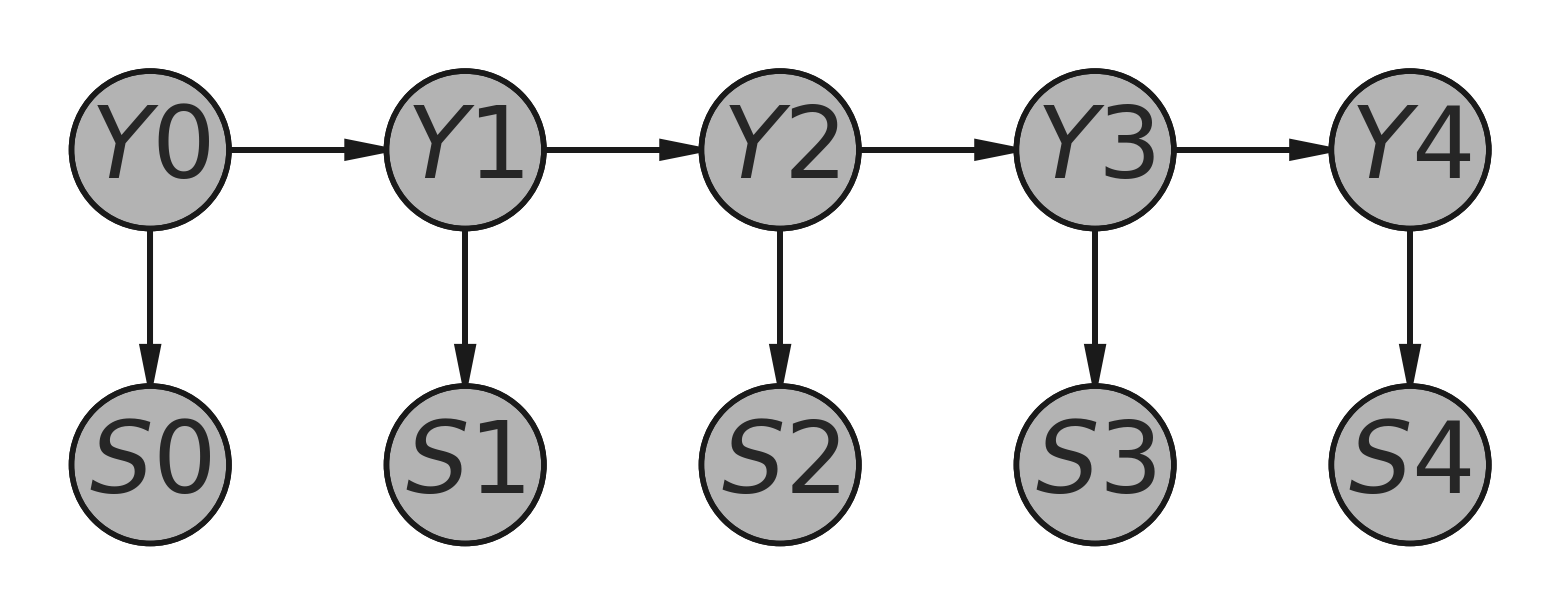

In [70]:
dbn = BayesianNetwork()
dbn.add_edges_from([('Y0', 'Y1'), 
                    ('Y1', 'Y2'), 
                    ('Y2', 'Y3'), 
                    ('Y3', 'Y4'), 
                    ('Y0', 'S0'),
                    ('Y1', 'S1'),
                    ('Y2', 'S2'),
                    ('Y3', 'S3'),
                    ('Y4', 'S4'),
                   ])
dbn.fit(df)
model_daft = dbn.to_daft(node_pos = {'Y0': [0,1],'Y1': [1,1],'Y2': [2,1],'Y3': [3,1],'Y4': [4,1],
                                     'S0': [0,0],'S1': [1,0],'S2': [2,0],'S3': [3,0],'S4': [4,0]},)
# To open the plot
model_daft.render(dpi = 400)

sts[0] = structure_score(dbn, df)

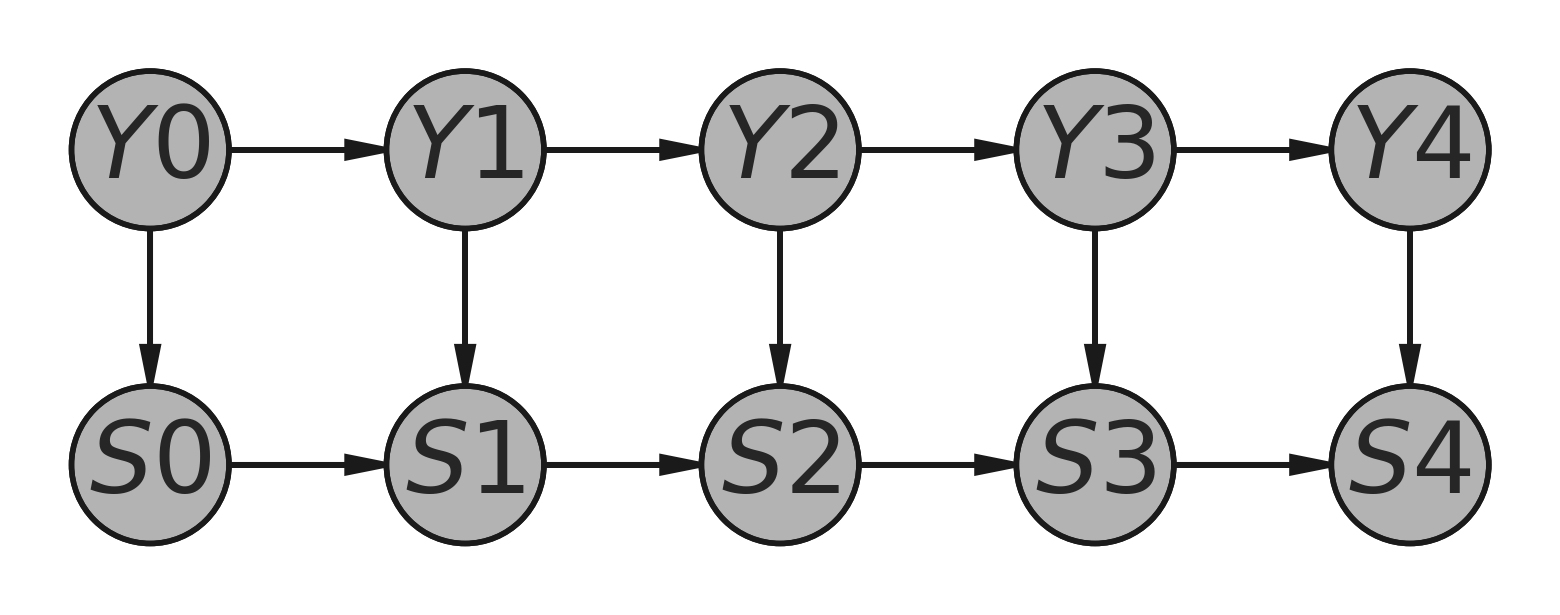

In [71]:
dbn = BayesianNetwork()
dbn.add_edges_from([('Y0', 'Y1'), 
                    ('Y1', 'Y2'), 
                    ('Y2', 'Y3'),
                    ('Y3', 'Y4'), 
                    ('Y0', 'S0'),
                    ('S0', 'S1'),
                    ('Y1', 'S1'),
                    ('S1', 'S2'),
                    ('Y2', 'S2'),
                    ('S2', 'S3'),
                    ('Y3', 'S3'),
                    ('S3', 'S4'),
                    ('Y4', 'S4'),
                   ])
dbn.fit(df)
model_daft = dbn.to_daft(node_pos = {'Y0': [0,1],'Y1': [1,1],'Y2': [2,1],'Y3': [3,1],'Y4': [4,1],
                                     'S0': [0,0],'S1': [1,0],'S2': [2,0],'S3': [3,0],'S4': [4,0]},)
# To open the plot
model_daft.render(dpi = 400)

sts[1] = structure_score(dbn, df)

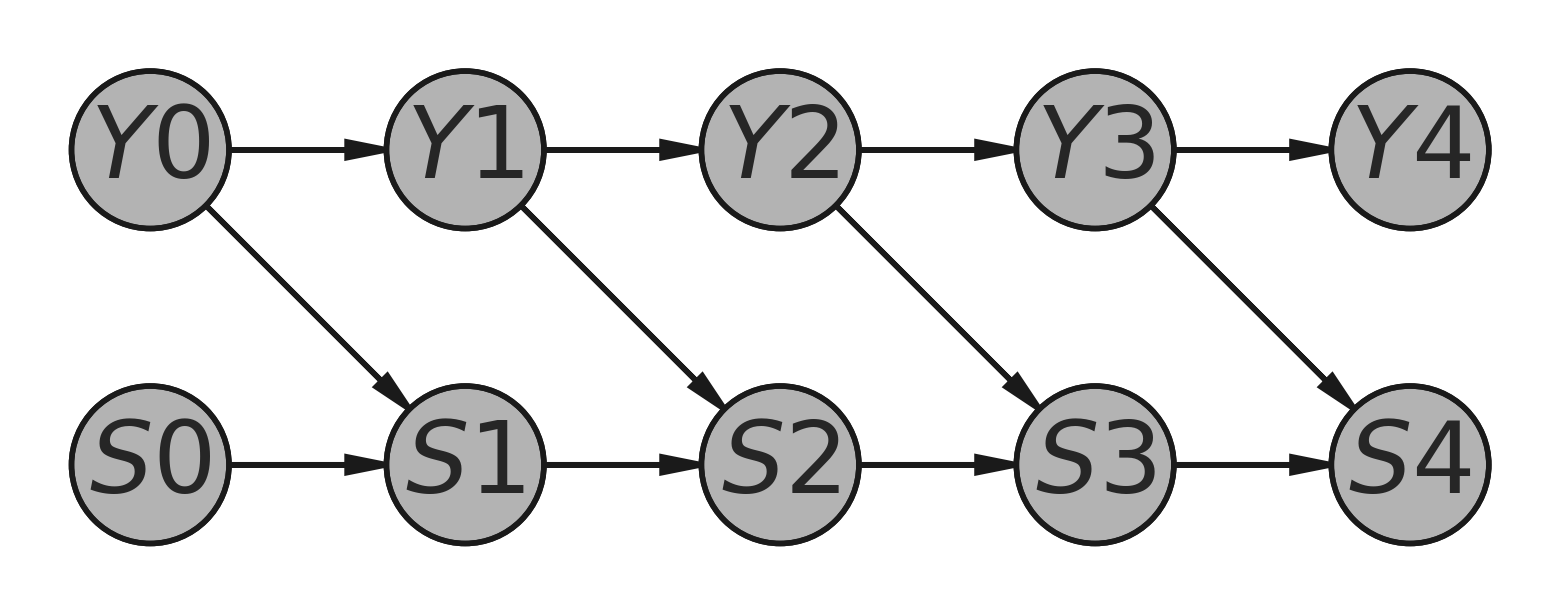

In [72]:
dbn = BayesianNetwork()
dbn.add_edges_from([('Y0', 'Y1'), 
                    ('Y1', 'Y2'), 
                    ('Y2', 'Y3'), 
                    ('Y3', 'Y4'), 
                    ('Y0', 'S1'),
                    ('S0', 'S1'),
                    ('Y1', 'S2'),
                    ('S1', 'S2'),
                    ('Y2', 'S3'),
                    ('S2', 'S3'),
                    ('Y3', 'S4'),
                    ('S3', 'S4'),
                   ])
dbn.fit(df)
model_daft = dbn.to_daft(node_pos = {'Y0': [0,1],'Y1': [1,1],'Y2': [2,1],'Y3': [3,1],'Y4': [4,1],
                                     'S0': [0,0],'S1': [1,0],'S2': [2,0],'S3': [3,0],'S4': [4,0]},)
# To open the plot
model_daft.render(dpi = 400)

sts[2] = structure_score(dbn, df)

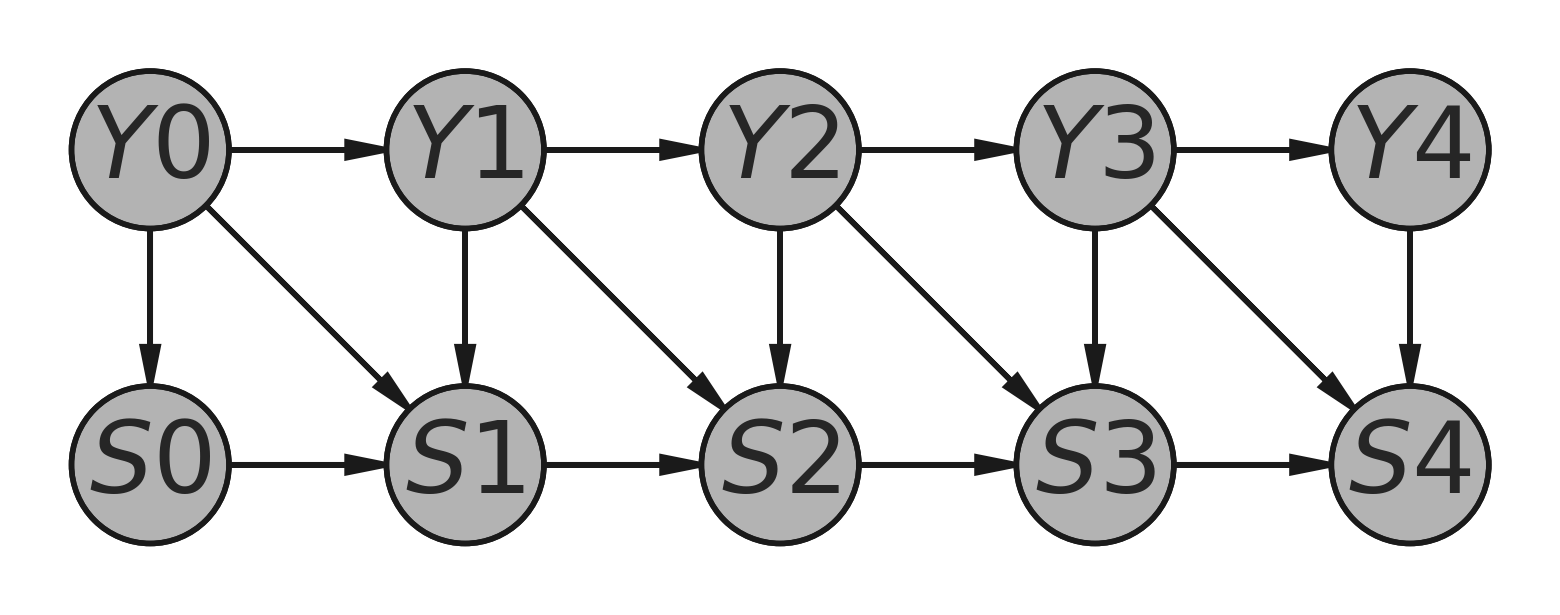

In [73]:
dbn = BayesianNetwork()
dbn.add_edges_from([('Y0', 'Y1'), 
                    ('Y1', 'Y2'), 
                    ('Y2', 'Y3'),
                    ('Y3', 'Y4'), 
                    ('Y0', 'S0'),
                    ('Y0', 'S1'),
                    ('S0', 'S1'),
                    ('Y1', 'S1'),
                    ('Y1', 'S2'),
                    ('S1', 'S2'),
                    ('Y2', 'S2'),
                    ('Y2', 'S3'),
                    ('S2', 'S3'),
                    ('Y3', 'S3'),
                    ('Y3', 'S4'),
                    ('S3', 'S4'),
                    ('Y4', 'S4'),
                   ])
dbn.fit(df)
model_daft = dbn.to_daft(node_pos = {'Y0': [0,1],'Y1': [1,1],'Y2': [2,1],'Y3': [3,1],'Y4': [4,1],
                                     'S0': [0,0],'S1': [1,0],'S2': [2,0],'S3': [3,0],'S4': [4,0]},)
# To open the plot
model_daft.render(dpi = 400)

sts[3] = structure_score(dbn, df)

In [74]:
sts

{0: -583.722580915189,
 1: -508.66740754197497,
 2: -494.17550713954705,
 3: -509.49041824364383}

In [75]:
pd.Series(sts).to_csv('results/analysis/YS_model_sts.csv')

## winning network

-494.17550713954705

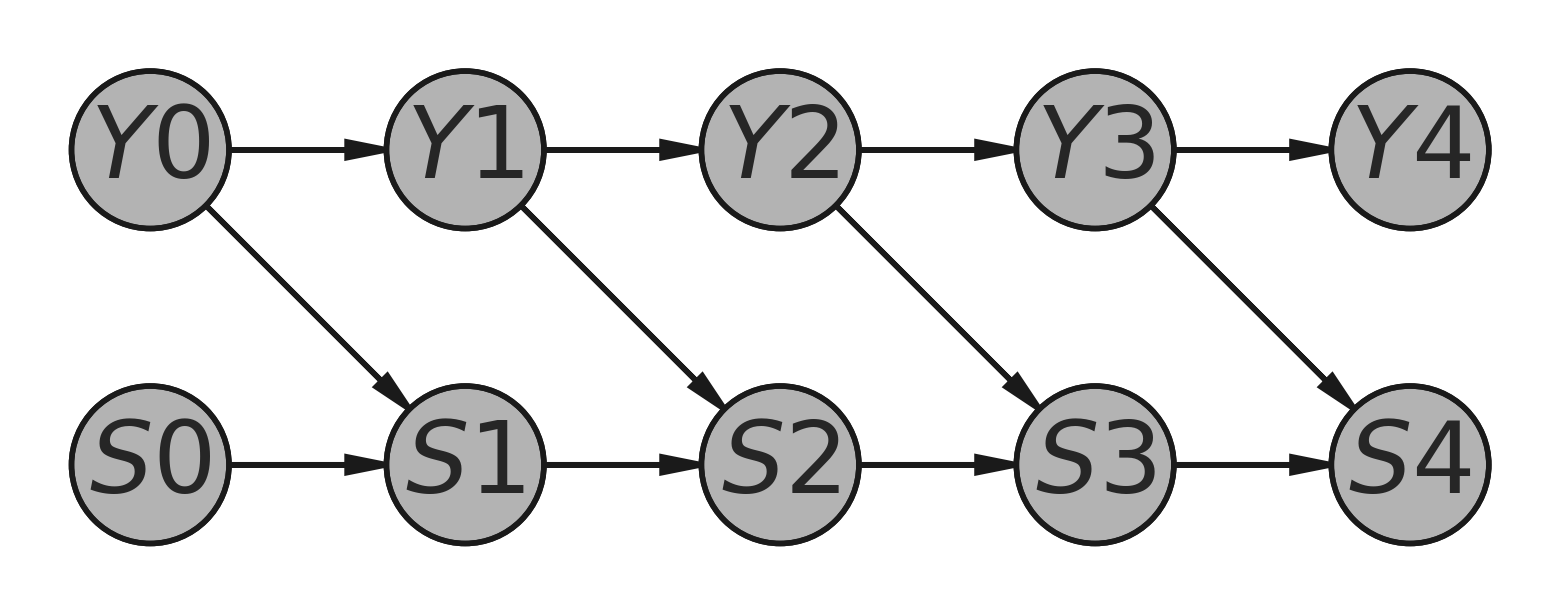

In [76]:
dbn = BayesianNetwork()
win_edg = [('Y0', 'Y1'), 
                    ('Y1', 'Y2'), 
                    ('Y2', 'Y3'), 
                    ('Y3', 'Y4'), 
                    ('Y0', 'S1'),
                    ('S0', 'S1'),
                    ('Y1', 'S2'),
                    ('S1', 'S2'),
                    ('Y2', 'S3'),
                    ('S2', 'S3'),
                    ('Y3', 'S4'),
                    ('S3', 'S4'),
                   ]
dbn.add_edges_from(win_edg)
dbn.fit(df)
model_daft = dbn.to_daft(node_pos = {'Y0': [0,1],'Y1': [1,1],'Y2': [2,1],'Y3': [3,1],'Y4': [4,1],
                                     'S0': [0,0],'S1': [1,0],'S2': [2,0],'S3': [3,0],'S4': [4,0]},)
# To open the plot
model_daft.render(dpi = 400)

structure_score(dbn, df)

# Simulate dynamics

In [77]:
cc = ['C'+str(i) for i in range(5)]
yy = ['Y'+str(i) for i in range(5)]
ss = ['S'+str(i) for i in range(5)]

In [83]:
n_embryos = 3000

### At the embryo level

In [79]:
# import time
# t0 = time.time()
# from joblib import Parallel, delayed
# boot_embs = Parallel(n_jobs=100)(delayed(simulate_once)(df, win_edg = win_edg, var_names = ['Y', 'S']) for i in range(n_embryos))
# t1 = time.time()
# print(t1-t0)

In [80]:
# # save
# import pickle
# f = open('results/analysis/bootstrapped_YS_embryos.p', 'wb')
# pickle.dump(boot_embs, f)
# f.close()

In [81]:
# save
import pickle
f = open('results/analysis/bootstrapped_YS_embryos.p', 'rb')
boot_embs = pickle.load(f)
f.close()

FileNotFoundError: [Errno 2] No such file or directory: 'results/analysis/bootstrapped_YS_embryos.p'

In [ ]:
embs = {}

for i in range(n_embryos):
    embs[i] = concatenate_embryo(boot_embs[i])

In [ ]:
props = {}
for i in range(n_embryos):
    props[i] = pd.Series([map_to_fs(tuple(x)) for x in embs[i][ss].values]).value_counts(normalize = True)
ap = pd.concat(props, axis = 1).fillna(0)

In [ ]:
plt.figure(figsize = (4,3), dpi = 400)
all_props = ap.stack().reset_index()
all_props.columns = ['Class', 'Embryo', 'Proportion']
sns.barplot(all_props, x = 'Class', y = 'Proportion', hue = 'Class',
            order = [ '$S^-$','$S^+_{16L}$','$S^+_{32E}$', '$S^+_{32L}$',],
           hue_order = [ '$S^-$','$S^+_{16L}$','$S^+_{32E}$','$S^+_{32L}$'],
                 palette = ['darkgray','dodgerblue',  'magenta', 'red'],
            errorbar=('sd', 1)
           )#.T.plot.bar()
plt.ylim(0, 0.8)

plt.savefig('figures_for_YSC_Bayesian_paper/S3B_2.png')
plt.savefig('figures_for_YSC_Bayesian_paper/S3B_2.svg')

In [ ]:
ap.mean(1), ap.std(1)

In [84]:
dbn = BayesianNetwork()
dbn.add_edges_from(win_edg)
dbn.fit(df)

In [85]:
dbn.save('results/analysis/YS_model_5_states.bif')

In [86]:
pd.DataFrame(df.values, 
             index = data.index,
            columns = df.columns).to_csv('results/analysis/data_for_YS_BN_5_states.csv')

In [87]:
# import time
# t0 = time.time()
# from joblib import Parallel, delayed
# raw_embs = Parallel(n_jobs=100)(delayed(simulate_embryo)(dbn, ['Y', 'S']) for i in range(n_embryos))
# t1 = time.time()
# print(t1-t0)

In [88]:
# # save
# import pickle
# f = open('results/analysis/simulated_YS_embryos.p', 'wb')
# pickle.dump(raw_embs, f)
# f.close()

In [89]:
# save
import pickle
f = open('results/analysis/simulated_YS_embryos.p', 'rb')
raw_embs = pickle.load(f)
f.close()

In [90]:
embs = {}

for i in range(n_embryos):
    embs[i] = concatenate_embryo(raw_embs[i])

In [91]:
props = {}
for i in range(n_embryos):
    props[i] = pd.Series([map_to_fs(tuple(x)) for x in embs[i][ss].values]).value_counts(normalize = True)

In [92]:
ap = pd.concat(props, axis = 1).fillna(0)

(0.0, 0.8)

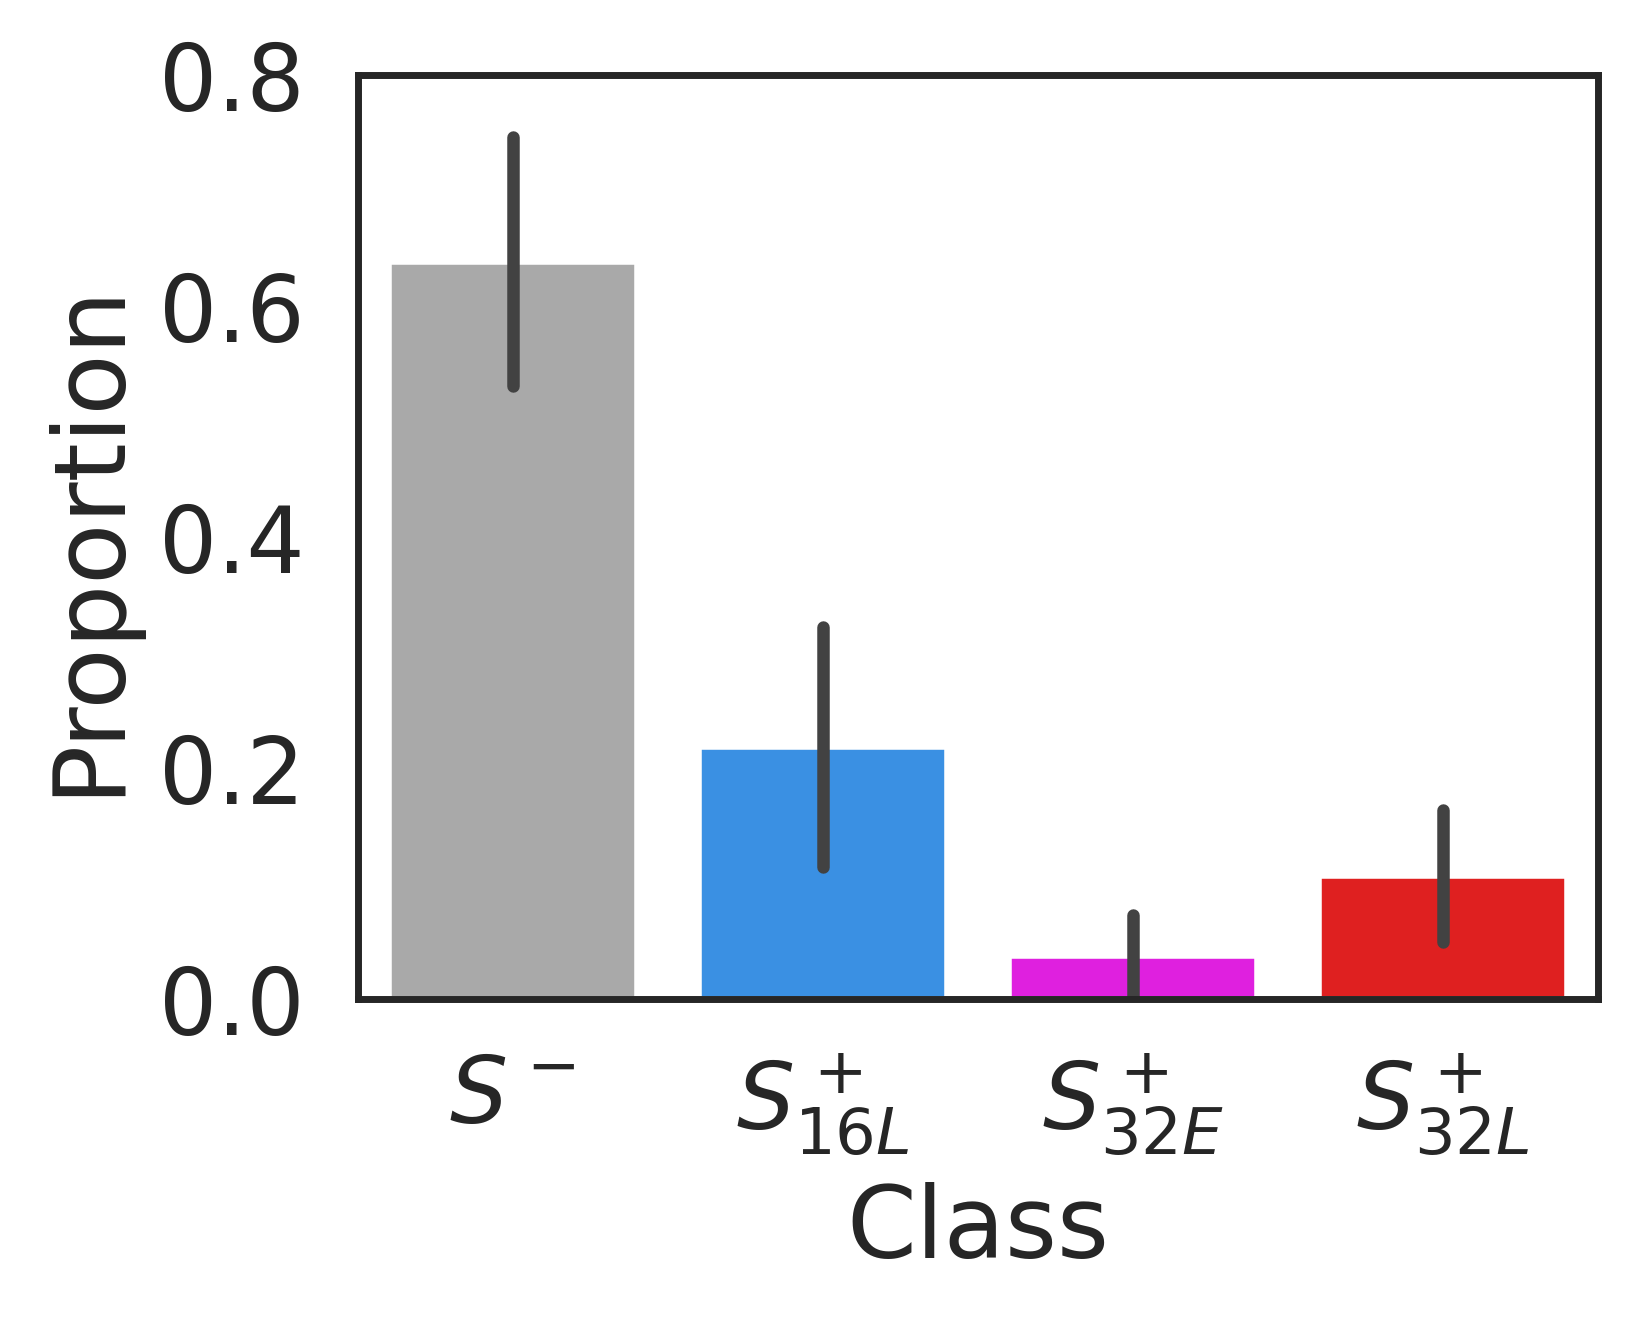

In [93]:
plt.figure(figsize = (4,3), dpi = 400)
all_props = ap.stack().reset_index()
all_props.columns = ['Class', 'Embryo', 'Proportion']
sns.barplot(all_props, x = 'Class', y = 'Proportion', hue = 'Class',
            order = [ '$S^-$','$S^+_{16L}$','$S^+_{32E}$', '$S^+_{32L}$',],
           hue_order = [ '$S^-$','$S^+_{16L}$','$S^+_{32E}$','$S^+_{32L}$'],
                 palette = ['darkgray','dodgerblue', 'magenta', 'red'],
            errorbar=('sd', 1)
           )#.T.plot.bar()
plt.ylim(0, 0.8)

# plt.savefig('figures_for_YSC_Bayesian_paper/3F.png')
# plt.savefig('figures_for_YSC_Bayesian_paper/3F.svg')

In [94]:
ap.mean(1), ap.std(1)

($S^-$          0.638125
 $S^+_{16L}$    0.218312
 $S^+_{32L}$    0.106573
 $S^+_{32E}$    0.036990
 dtype: float64,
 $S^-$          0.107778
 $S^+_{16L}$    0.103686
 $S^+_{32L}$    0.057223
 $S^+_{32E}$    0.035963
 dtype: float64)

## Variable Elimination

In [95]:
dbn = BayesianNetwork()
dbn.add_edges_from(win_edg)
dbn.fit(df)

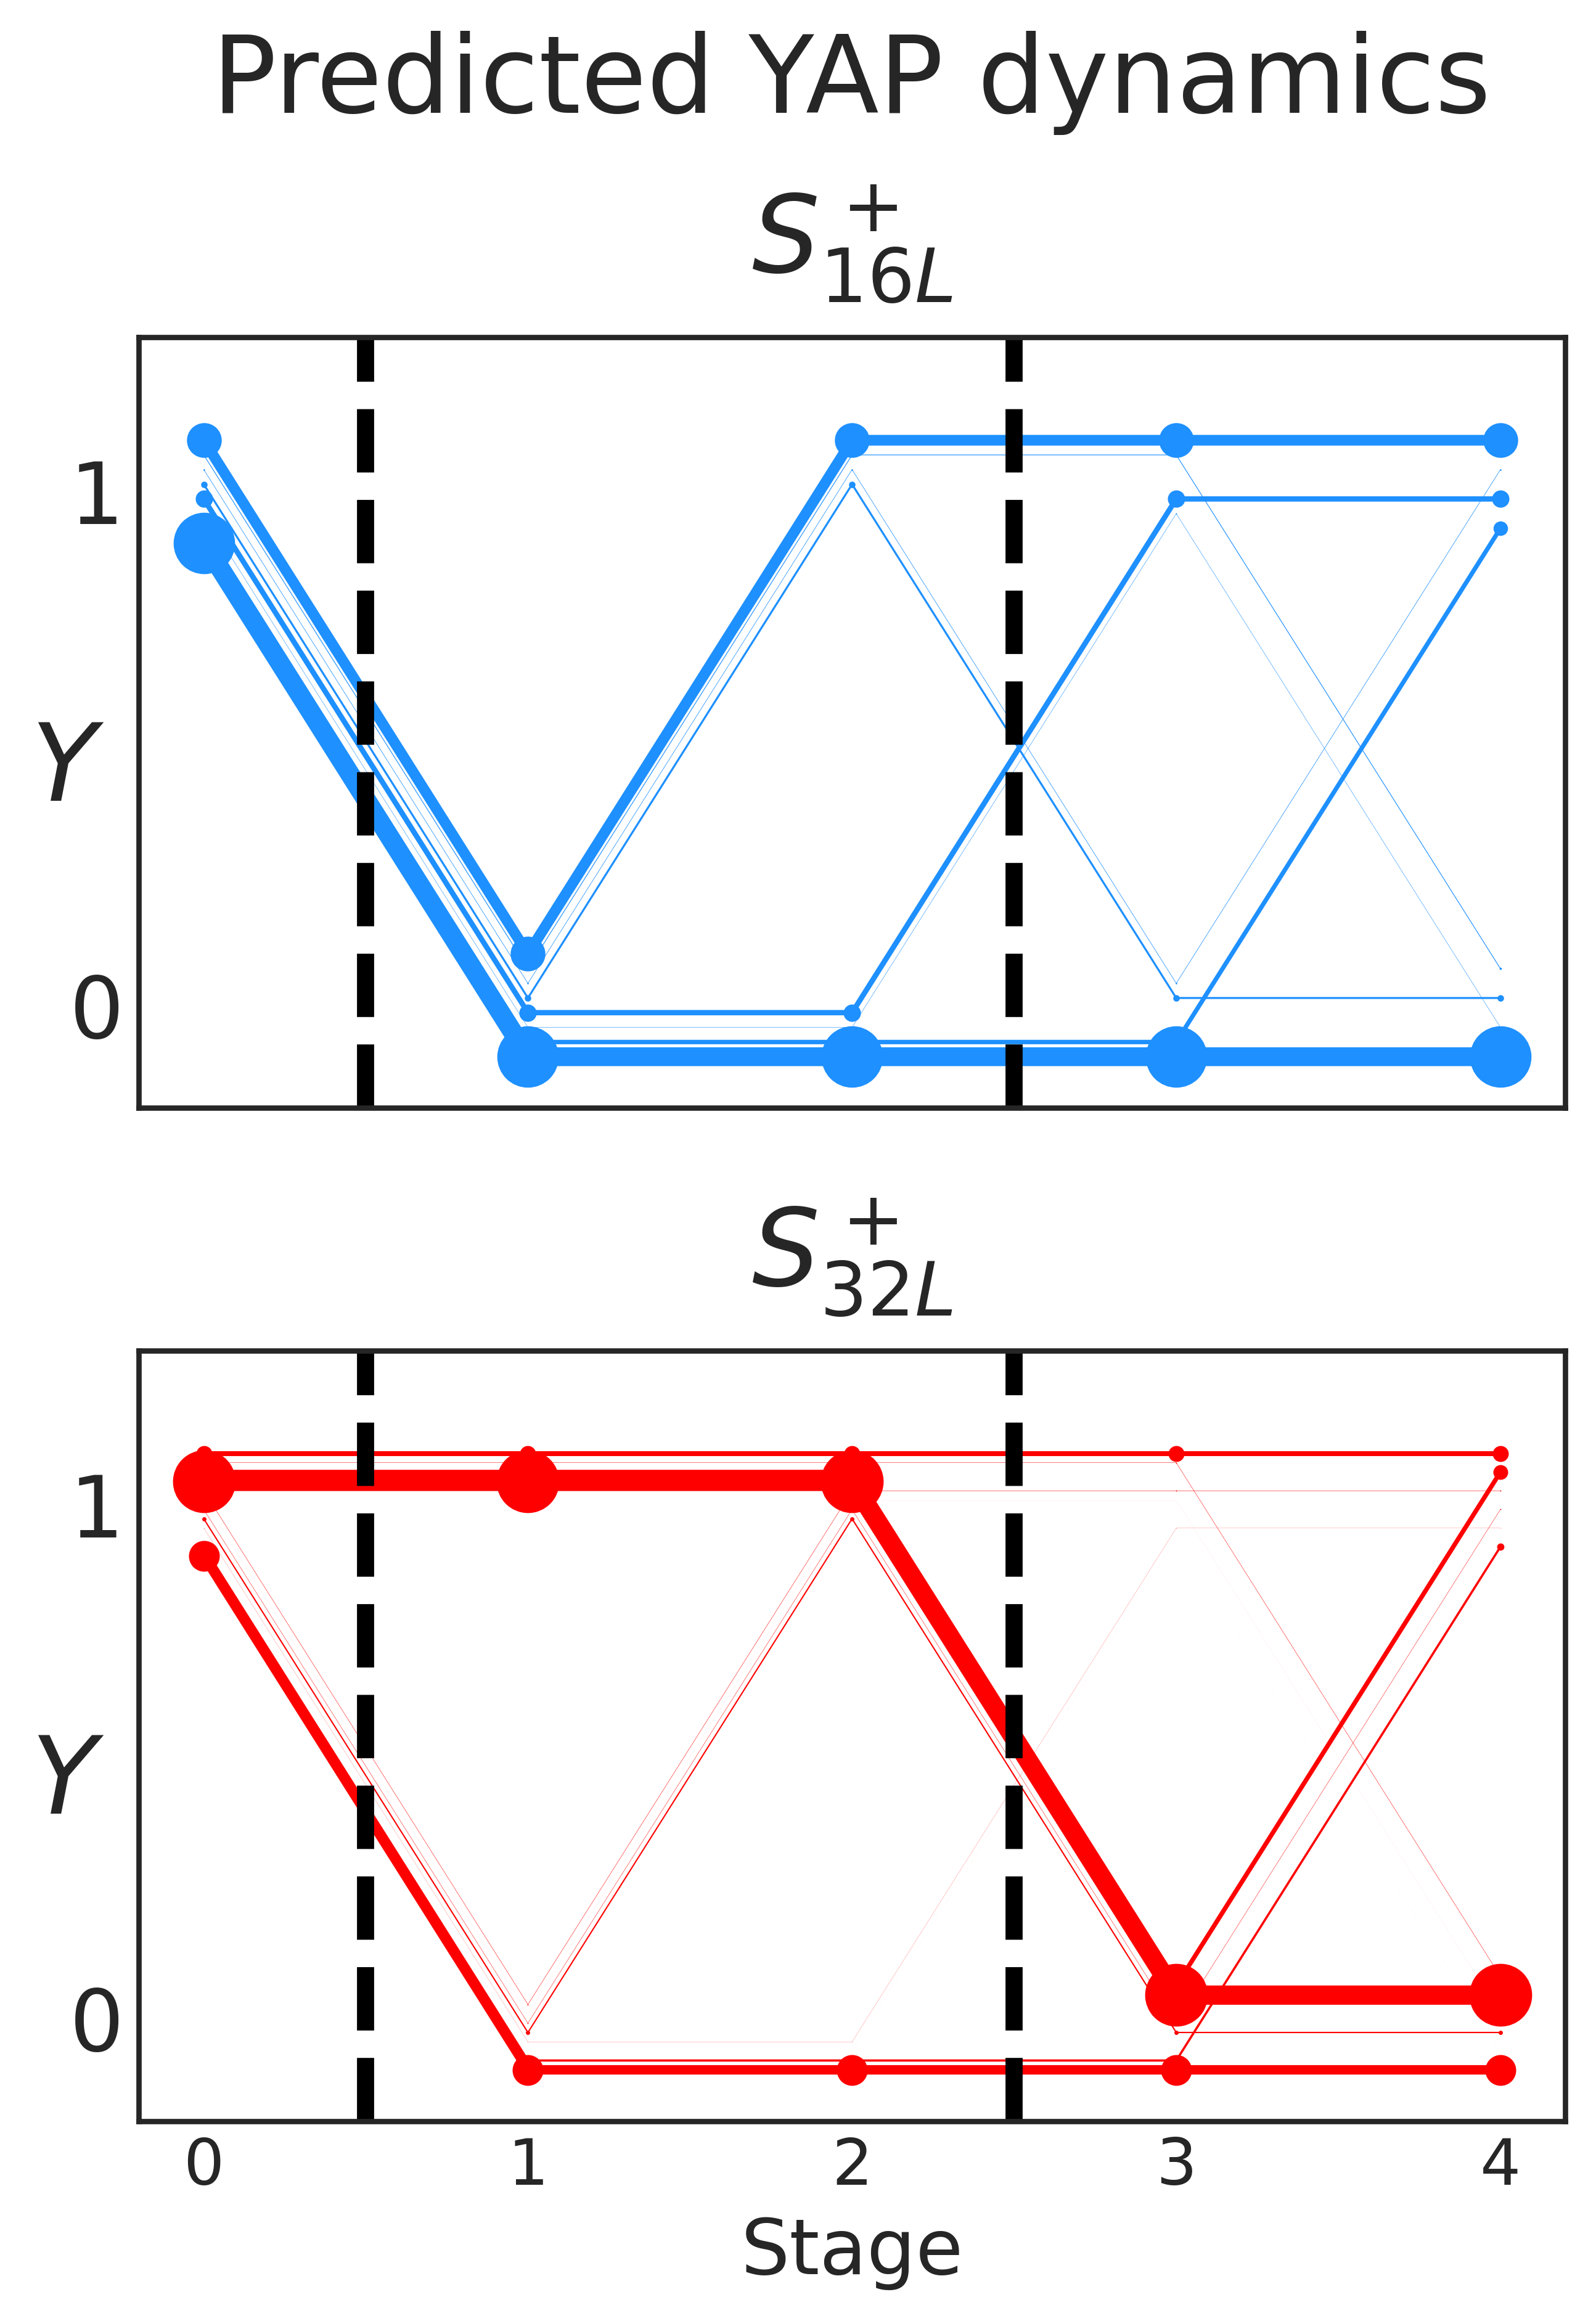

In [96]:
fig, axes = plt.subplots(2,1,figsize = (5.5,8), dpi = 500, sharex = True)

ax = axes[0]
ve = var_elim(dbn, 
         ['Y0', 'Y1', 'Y2', 'Y3', 'Y4'], 
         {'S2': 1})
plot_var_elim(ve, 
         lbl = 'Y', 
         title = '$S^+_{16L}$',#'$P(Y_{t=0\ldots 4}|C^+_{16L}, C^+)$',
        color = 'dodgerblue', figsize = (6,3), 
              ylim = (-0.2, 1.3), title_font = 25,
              lw = 10,lbl_y = 0.37,
              dpi = 500, ax = ax)

ax = axes[1]
ve = var_elim(dbn, 
         ['Y0', 'Y1', 'Y2', 'Y3', 'Y4'], 
         {'S2': 0, 'S3': 0, 'S4':1})
plot_var_elim(ve, 
         lbl = 'Y', 
         title = '$S^+_{32L}$',
        color = 'red', figsize = (6,3), 
              ylim = (-0.2, 1.3), title_font = 25,
              lw = 10,lbl_y = 0.37,
              dpi = 500, ax = ax)
plt.suptitle('Predicted YAP dynamics', y = 0.95, x = 0.53, fontsize = 25)
plt.tight_layout()
# plt.savefig('figures_for_YSC_Bayesian_paper/3H.png')
# plt.savefig('figures_for_YSC_Bayesian_paper/3H.svg')

In [97]:
ve = var_elim(dbn, 
         ['Y0', 'Y1', 'Y2', 'Y3', 'Y4'], 
         {'S2': 1})
# for figures
print(ve.loc[(1,0,0,0,0),:], ve.loc[(1,0,1,1,1),:])
# for text
ve.groupby('Y1').sum()


proportion    0.440476
Name: (1, 0, 0, 0, 0), dtype: float64 proportion    0.249424
Name: (1, 0, 1, 1, 1), dtype: float64


proportion
Y1            
0          1.0

In [98]:
ve = var_elim(dbn, 
         ['Y0', 'Y1', 'Y2', 'Y3', 'Y4'], 
         {'S2': 0, 'S3': 0, 'S4':1})
# for figures
print(ve.loc[(1,0,0,0,0),:], ve.loc[(1,1,1,0,0),:])
# for text
#loss of YAP at first division
print(ve.groupby('Y1').sum())
#loss of YAP at second division
print(ve.query('Y2 == 1').query('Y3 == 0').sum())

proportion    0.220972
Name: (1, 0, 0, 0, 0), dtype: float64 proportion    0.449889
Name: (1, 1, 1, 0, 0), dtype: float64
    proportion
Y1            
0     0.322112
1     0.677888
proportion    0.593446
dtype: float64


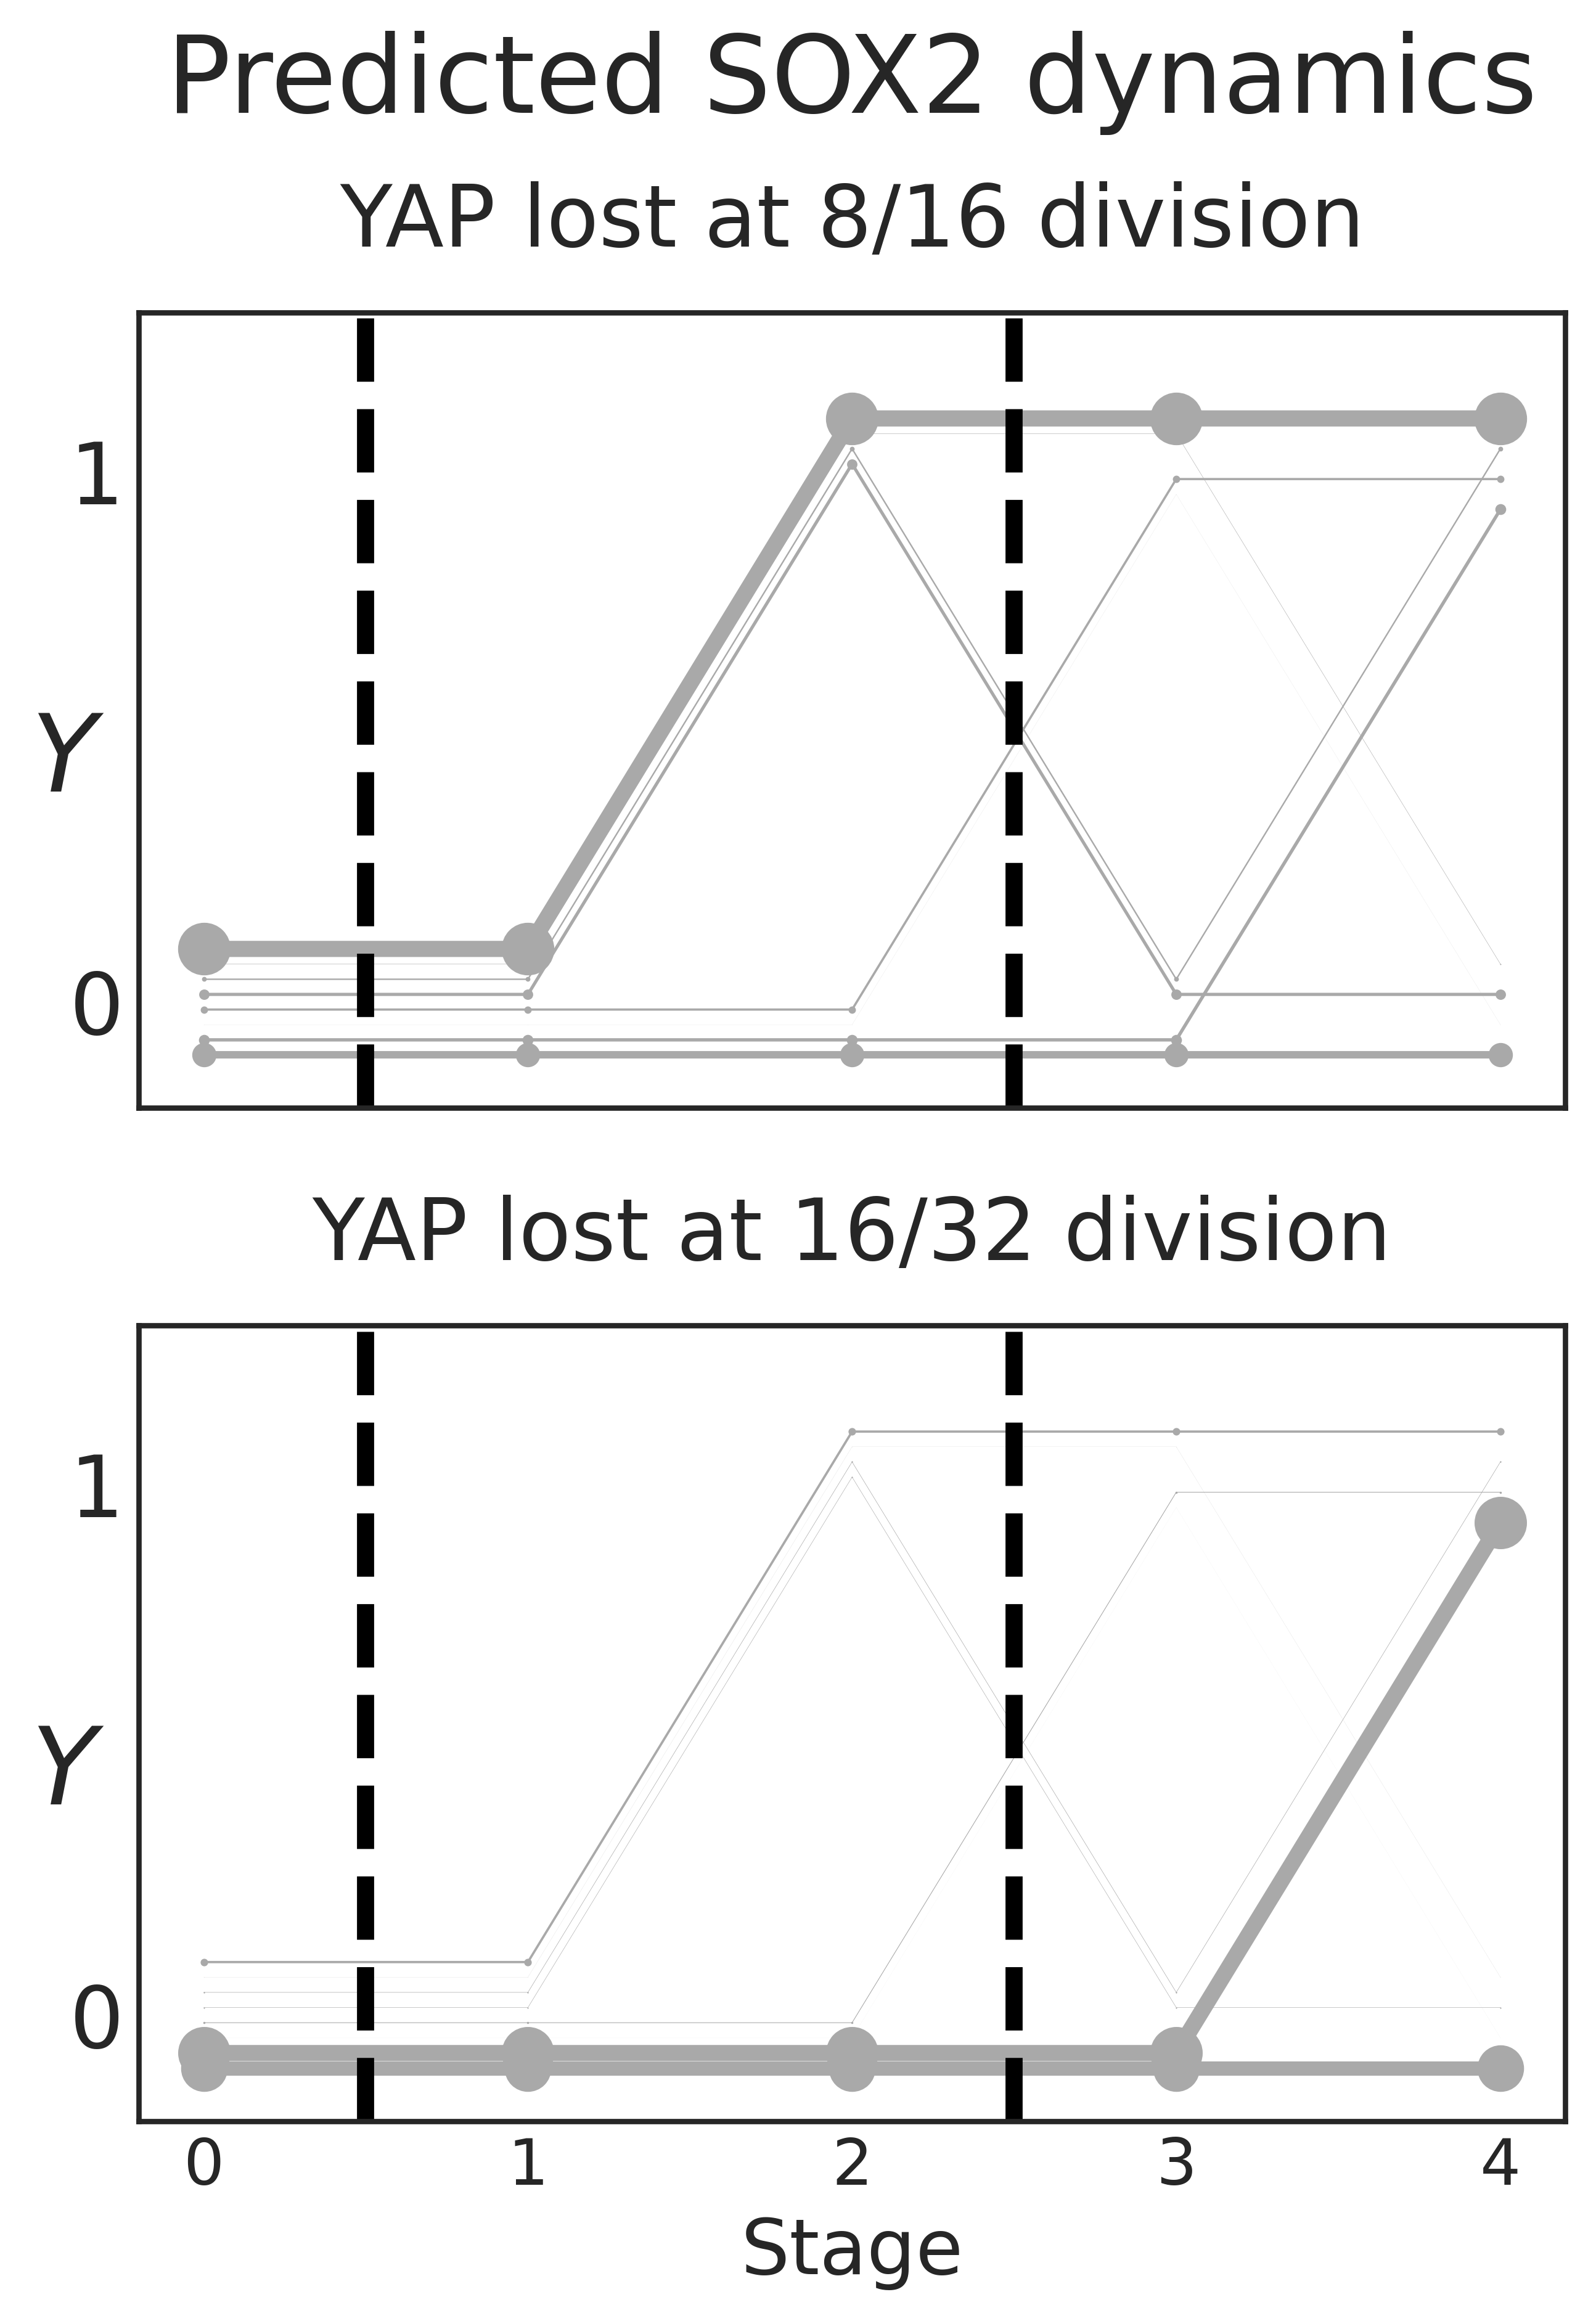

In [99]:
fig, axes = plt.subplots(2,1,figsize = (5.5,8), dpi = 500, sharex = True, sharey = False)

ax = axes[0]
ve = var_elim(dbn, 
         ['S0', 'S1', 'S2', 'S3', 'S4'], 
         {'Y1':0})
plot_var_elim(ve, 
         lbl = 'Y', 
         title = 'YAP lost at 8/16 division',#'$P(Y_{t=0\ldots 4}|C^+_{16L}, C^+)$',
        color = 'darkgray', figsize = (6,3), 
              ylim = (-0.2, 1.3), title_font = 20,
              dpi = 500, ax = ax, lw = 8, 
              lbl_y = 0.37)


ax = axes[1]
ve = var_elim(dbn, 
         ['S0', 'S1', 'S2', 'S3', 'S4'], 
         {'Y2': 1, 'Y3':0})
plot_var_elim(ve, 
         lbl = 'Y', 
         title = 'YAP lost at 16/32 division',
        color = 'darkgray', figsize = (6,3), 
              ylim = (-0.2, 1.3),title_font = 20,
              dpi = 500, ax = ax, lw = 8, lbl_y = 0.37)

plt.suptitle('Predicted SOX2 dynamics', y = 0.95, x = 0.53, fontsize = 25)
plt.tight_layout()
# plt.savefig('figures_for_YSC_Bayesian_paper/3I.png')
# plt.savefig('figures_for_YSC_Bayesian_paper/3I.svg')

In [100]:
ve = var_elim(dbn, 
         ['S0', 'S1', 'S2', 'S3', 'S4'], 
         {'Y1':0})
# for text
#loss of YAP at first division
print(ve.groupby('S2').sum())

    proportion
S2            
0     0.382353
1     0.617647


In [101]:
ve = var_elim(dbn, 
         ['S0', 'S1', 'S2', 'S3', 'S4'], 
         {'Y2': 1, 'Y3':0})
# for text
#loss of YAP at first division
print(ve.groupby('S4').sum())

    proportion
S4            
0     0.431549
1     0.568451


In [102]:
ve

proportion
S0 S1 S2 S3 S4            
0  0  0  0  0     0.417512
            1     0.469702
         1  0     0.000680
            1     0.019036
      1  0  0     0.010949
            1     0.012318
         1  0     0.002407
            1     0.067396

# Triple data

In [103]:
true_dp = [('240120_stack_0', '2_2'),
            ('240120_stack_0', '1_0'),
            ('240116_stack_2', '1_1'),
            ('240120_stack_0', '4_2')]

In [104]:
true_dp_stack0 = [('240120_stack_0', '1_0'),
            ('240120_stack_0', '2_2'),
            ('240120_stack_0', '4_2')]
true_dp_stack2 = [('240116_stack_2', '1_1')]

In [105]:
TF = 'Cdx2'
minmax_tf(TF, dat_full); minmax_tf('Total_'+TF, dat_full)

In [106]:
mins_cdx2 = dat_full.groupby(['stack', 'Time'])['Smooth_Total_Cdx2_Minmax'].min()
dat_full['Smooth_Total_Cdx2_Minmax_corr'] =dat_full['Smooth_Total_Cdx2_Minmax']-mins_cdx2.loc[dat_full.reset_index().set_index(['stack', 'Time']).index].values

Text(0.5, 0, 'Cell stage')

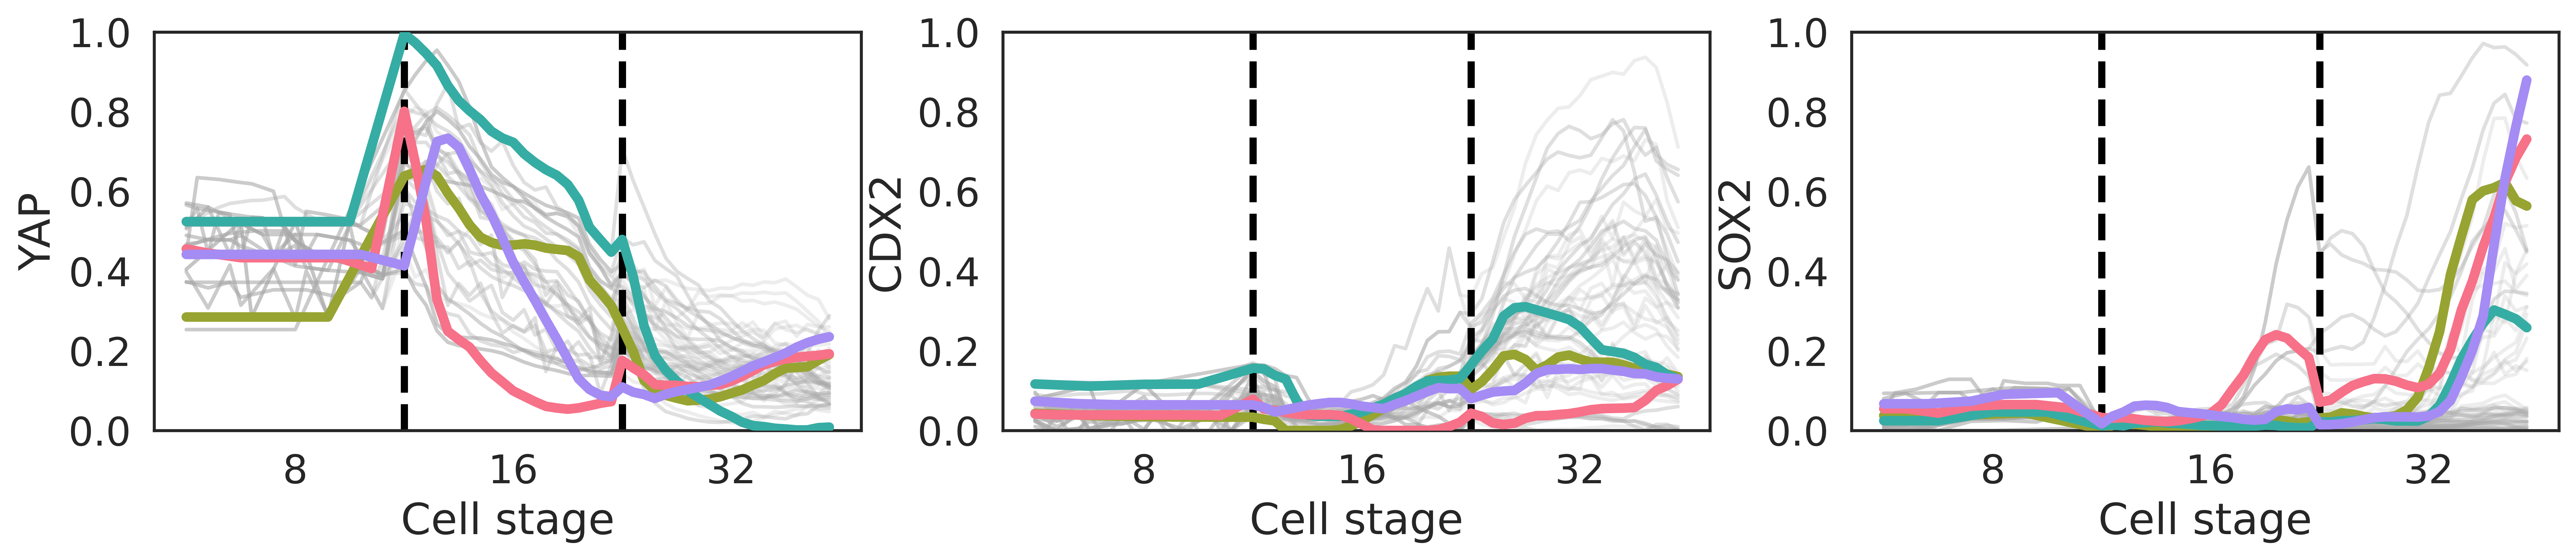

In [107]:
sns.set(palette = 'hls', style = 'white', font_scale = 1.5)
fig, axes = plt.subplots(1,3,dpi = 600, figsize = (18,3), sharey = False)
rel_dat = dat_full.reset_index().set_index(['stack', 'Branch'])
rd = rel_dat.loc[true_dp,:]._get_numeric_data().groupby(['Branch','Warped_time']).mean().reset_index().query('Gen <= 3')
rd0 =rel_dat.loc[['240120_stack_0', '240116_stack_2'],:]._get_numeric_data().groupby(['Branch','Warped_time']).mean().reset_index().query('Gen <= 3')
pal = dict(zip([x[1] for x in true_dp], sns.color_palette('husl', 4)))
ax = axes[0]
sns.lineplot(rd,ax = ax,
             x = 'Warped_time', y = 'Smooth_Yap_Minmax',
             units = 'Branch', estimator = None, hue = 'Branch', 
             palette = pal, legend = False,alpha = 1,zorder = 7,
            lw = 4)
sns.lineplot(rd0, ax = ax,
             x = 'Warped_time', y = 'Smooth_Yap_Minmax',
             units = 'Branch', estimator = None, color = 'darkgray', alpha = 0.2,
             legend = False)
ax.set_ylabel('YAP')
ax.axvline(1, linestyle = '--', c = 'black', lw = 3)
ax.axvline(2, linestyle = '--', c = 'black', lw = 3)
ax.set_xlabel('')
ax.set_xticks([0.5, 1.5, 2.5], ['8', '16', '32'])
ax.set_ylim(0,1)
ax.set_xlabel('Cell stage')
#ax.axvline(107, c = 'black', linestyle = '--')
ax = axes[2]
sns.lineplot(rd, ax = ax,
             x = 'Warped_time', y = 'Smooth_Total_Sox2_Minmax_corr',#'Total_Sox2'
             units = 'Branch', estimator = None, hue = 'Branch', 
             palette = pal, legend = False, alpha = 1,zorder = 7,
            lw = 4)

sns.lineplot(rd0, ax = ax,
             x = 'Warped_time', y = 'Smooth_Total_Sox2_Minmax_corr',
             units = 'Branch', estimator = None, color = 'darkgray', alpha = 0.2,
             legend = False)
ax.set_ylabel('SOX2')
#ax.axvline(107, c = 'black', linestyle = '--')
ax.axvline(1, linestyle = '--', c = 'black', lw = 3)
ax.axvline(2, linestyle = '--', c = 'black', lw = 3)
ax.set_xlabel('')
ax.set_xticks([0.5, 1.5, 2.5], ['8', '16', '32'])
ax.set_ylim(0,1)
ax.set_xlabel('Cell stage')
ax = axes[1]
sns.lineplot(rd, ax = ax,
             x = 'Warped_time', y = 'Smooth_Total_Cdx2_Minmax_corr',
             units = 'Branch', estimator = None, hue = 'Branch', 
             palette = pal, legend = False, alpha = 1, zorder = 7,
            lw = 4)

sns.lineplot(rd0, ax = ax,
             x = 'Warped_time', y = 'Smooth_Total_Cdx2_Minmax_corr',
             units = 'Branch', estimator = None, color = 'darkgray', alpha = 0.2,
             legend = False)
ax.set_ylabel('CDX2')
#ax.axvline(107, c = 'black', linestyle = '--')
ax.axvline(1, linestyle = '--', c = 'black', lw = 3)
ax.axvline(2, linestyle = '--', c = 'black', lw = 3)
ax.set_xlabel('')
ax.set_xticks([0.5, 1.5, 2.5], ['8', '16', '32'])
ax.set_ylim(0,1)
ax.set_xlabel('Cell stage')
#plt.tight_layout()

# fig.savefig('figures_for_YSC_Bayesian_paper/4F_2.png', dpi = 500)
# fig.savefig('figures_for_YSC_Bayesian_paper/4F_2.svg', dpi = 500)